
# High-Throughput Experimental Materials (HTEM) Database

The **High-Throughput Experimental Materials (HTEM) Database** hosted at [htem.nrel.gov](https://htem.nrel.gov) is a publicly accessible platform developed by the National Renewable Energy Laboratory (NREL). It provides a wealth of experimental data on materials synthesized and characterized through high-throughput methods. The database supports the discovery and optimization of novel materials by offering detailed information on composition, structure, processing conditions, and corresponding properties.

Researchers can leverage the HTEM database to:
- Explore large datasets for materials research.
- Identify trends in materials properties and synthesis conditions.
- Accelerate materials development using data-driven approaches.

For more information or to access the database, visit [htem.nrel.gov](https://htem.nrel.gov).



In [1]:
#Note: the API available online for accessing htem.nrel.gov did not work for us, so we updated it (credit Reid Wetherington)

# Setting Up the Library

To use the custom library, follow these steps:

1. Put `lib.zip` in your working directory (./)
2. Unzip `lib.zip` (e.g. using right-click Extract All)
   

In [1]:
#Append lib to your path so you get access to the libraries to navigate HTEM database
import sys
import pandas as pd
sys.path.append('./lib')
from library import Library #custom from ./lib
from sample import Sample #custom from ./lib
import seaborn 

# Downloading Libraries from the HTEM Database

The below script fetches all sample libraries from the HTEM database and organizes them into a DataFrame. It:

1. Queries the HTEM API for library metadata.
2. Uses the `Library` class to retrieve detailed properties.
3. Combines properties into a Pandas DataFrame.
4. Displays a progress bar with `tqdm`.

The final DataFrame (`all_libraries_df`) contains all retrieved library information for analysis.


In [2]:
comment this line and run to download all of the libraries - takes ~8 minutes to download

import urllib.request
import json
import pandas as pd
from tqdm.notebook import tqdm  # For Jupyter Notebook-compatible progress bar

def download_all_libraries():
    """
    Downloads all available libraries from the HTEM database and stores them in a DataFrame.
    Returns:
        libraries_df (pd.DataFrame): A DataFrame containing all the library data.
    """
    try:
        # Base URL to fetch all libraries
        url = 'https://htem-api.nrel.gov/api/sample_library'
        
        # Make a request to the API
        with urllib.request.urlopen(url) as response:
            data = json.load(response)
        
        # Extract library IDs
        library_ids = [library['id'] for library in data]
        
        # Create a list of Library objects using the Library class
        libraries = Library.search_by_ids(library_ids)
        
        # Initialize a list to store all library properties
        all_properties = []
        
        # Loop through each Library object and fetch its properties
        for lib in tqdm(libraries, desc="Downloading Libraries", unit="library"):
            lib_properties = lib.properties()
            if not lib_properties.empty:
                all_properties.append(lib_properties)
        
        # Concatenate all properties into a single DataFrame at the end
        if all_properties:
            libraries_df = pd.concat(all_properties, ignore_index=True)
        else:
            libraries_df = pd.DataFrame()
        
        return libraries_df
    
    except Exception as e:
        print(f"An error occurred while downloading libraries: {e}")
        return pd.DataFrame()

# Fetch all libraries and store them in a DataFrame
all_libraries_df = download_all_libraries()

# Display the DataFrame
if not all_libraries_df.empty:
    print("Successfully downloaded all libraries!")
else:
    print("No libraries were downloaded.")


C:\Users\mjym8d\AppData\Local\Temp\ipykernel_7196\3185319014.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  libraries_df = pd.concat(all_properties, ignore_index=True)


Successfully downloaded all libraries!


In [3]:
# Save the DataFrame to a Parquet file
comment this line and run to save the data to a parquet file
if not all_libraries_df.empty:
    output_file = "HTEM_all_libraries.parquet"
    all_libraries_df.to_parquet(output_file, engine='pyarrow', index=False)
    print(f"DataFrame successfully saved to {output_file}")
else:
    print("DataFrame is empty. Nothing to save.")


DataFrame successfully saved to HTEM_all_libraries.parquet


In [4]:
#Load the dataframe back into memory
import pandas as pd

# File path to the Parquet file
input_file = "HTEM_all_libraries.parquet"

# Read the Parquet file into a DataFrame
try:
    all_libraries_df = pd.read_parquet(input_file, engine='pyarrow')
    print("DataFrame successfully loaded from Parquet file.")
except FileNotFoundError:
    print(f"The file {input_file} was not found.")
except Exception as e:
    print(f"An error occurred while reading the Parquet file: {e}")


DataFrame successfully loaded from Parquet file.


In [5]:
all_libraries_df.keys()

Index(['id', 'num', 'pdac', 'quality', 'person_id', 'sample_date',
       'owner_name', 'owner_email', 'xrf_type', 'sputter_operator',
       'sample_ids', 'elements', 'xrf_elements', 'xrf_compounds',
       'deposition_sample_time_min', 'deposition_compounds',
       'deposition_power', 'deposition_base_pressure_mtorr',
       'deposition_growth_pressure_mtorr', 'deposition_target_pulses',
       'deposition_rep_rate', 'deposition_energy', 'deposition_cycles',
       'deposition_ts_distance', 'deposition_initial_temp_c', 'box_number',
       'deposition_gases', 'deposition_substrate_material',
       'deposition_gas_flow_sccm', 'has_xrd', 'has_xrf', 'has_ele', 'has_opt',
       'data_access'],
      dtype='object')

In [6]:
max(all_libraries_df['has_opt'])

177

### Visualizing Composition and XRD Data

1. **Elemental Composition**:
- Visualize the distribution of elements (by atomic number) present in the database.

2. **XRD Data Coverage**:
- Show the fraction of measurements that include XRD data.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_composition_and_xrd(libraries_df):
    """
    Visualizes:
    1. Elemental composition based on atomic number.
    2. Availability of XRD data.
    """
    # Ensure DataFrame is not empty
    if libraries_df.empty:
        print("The library data is empty. Cannot create visualizations.")
        return
    
    # Elemental Composition (Atomic Number Distribution)
    if 'elements' in libraries_df.columns:
        # Flatten the list of elements for all libraries and calculate frequencies
        elemental_data = libraries_df['elements'].dropna().explode()
        elemental_counts = elemental_data.value_counts().sort_index()
        
        plt.figure(figsize=(10, 6))
        plt.bar(elemental_counts.index, elemental_counts.values, width=0.8)
        plt.title("Elemental Composition by Atomic Number", fontsize=14)
        plt.xlabel("Atomic Number", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("No elemental composition data available.")
    
    # Availability of XRD Data
    if 'has_xrd' in libraries_df.columns:
        xrd_availability = libraries_df['has_xrd'] > 0
        xrd_summary = xrd_availability.value_counts()
        
        plt.figure(figsize=(6, 6))
        plt.pie(
            xrd_summary.values,
            labels=["XRD Available", "No XRD Data"],
            autopct='%1.1f%%',
            startangle=140,
            colors=['#76c7c0', '#f88a8a']
        )
        plt.title("Availability of XRD Data", fontsize=14)
        plt.show()
    else:
        print("No XRD data information available.")


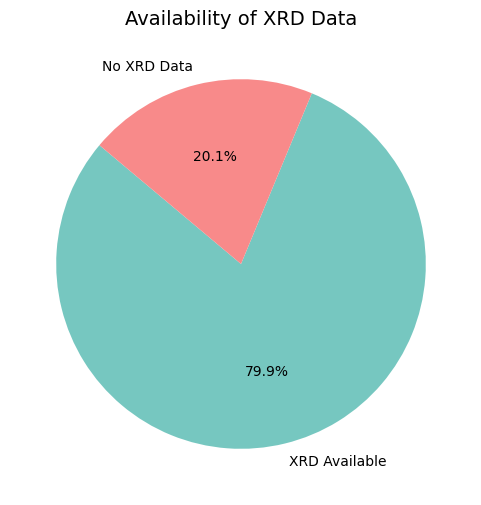

In [8]:
visualize_composition_and_xrd(all_libraries_df)

### Visualizing Optical and Electronic Data

This script analyzes data from the HTEM database by:

1. **Data Availability**:
   - Visualizing the proportion of libraries with optical data, electronic data, both, or neither.

2. **Purpose**:
   - Provides insights into the coverage of optical and electronic measurements in the database.

In [9]:
def visualize_electronic_and_optical(libraries_df):
    """
    Visualizes:
    1. Proportion of libraries with optical and electronic data.
    2. Distribution of optical band gap and electronic conductivity.
    """
    # Ensure DataFrame is not empty
    if libraries_df.empty:
        print("The library data is empty. Cannot create visualizations.")
        return
    
    # Filter libraries with optical or electronic data
    optical_libraries = libraries_df[libraries_df['has_opt'] > 0]
    electronic_libraries = libraries_df[libraries_df['has_ele'] > 0]
    both_data_libraries = libraries_df[(libraries_df['has_opt'] > 0) & (libraries_df['has_ele'] > 0)]
    
    # Summary visualization
    categories = {
        "Optical Only": len(optical_libraries) - len(both_data_libraries),
        "Electronic Only": len(electronic_libraries) - len(both_data_libraries),
        "Both Optical and Electronic": len(both_data_libraries),
        "Neither": len(libraries_df) - len(optical_libraries) - len(electronic_libraries)
    }
    
    # Pie chart for data availability
    plt.figure(figsize=(8, 8))
    plt.pie(
        categories.values(),
        labels=categories.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=['#76c7c0', '#f88a8a', '#fbd46d', '#adb5bd']
    )
    plt.title("Proportion of Libraries with Optical and Electronic Data", fontsize=14)
    plt.show()


In [10]:
visualize_electronic_and_optical(all_libraries_df)

# Dealing with Missing Data

Reference: [IEEE Article](https://ieeexplore.ieee.org/stamp/stamp.jsp)

Approaches to handle missing data include:

1. **Discard**: Ignore instances with missing data inputs.
2. **Default**: Use a predefined value (user/system-defined) as a substitute.
3. **Historic Data**: Utilize prior complete data or previously observed missing data patterns.
4. **Current Data**: Leverage data from other present instances where the missing data inputs are available.
5. **A Priori**: Apply external high-level knowledge about the data.
6. **Prediction**: Combine any of the above methods with the current observed data to estimate missing values.


## Filtering Libraries with Both Optical and Electronic Data

After visualizing the proportion of libraries containing optical and electronic data, the next step is to focus on libraries that include both data types. This script:

1. **Purpose**:
   - Identifies and extracts entries from the HTEM database that contain **UV-vis optical data** and **electronic conductivity data**.

2. **Process**:
   - Ensures the dataset is not empty and contains the required columns (`has_opt` and `has_ele`).
   - Filters the DataFrame to include only rows where both data types are available.

3. **Output**:
   - Returns a new DataFrame (`filtered_libraries_df`) with libraries having both optical and electronic data for targeted analysis.

This step narrows the dataset to focus on entries rich in complementary data for deeper exploration.


In [11]:
import pandas as pd

def filter_libraries_with_optical_and_electronic_data(libraries_df):
    """
    Filters the libraries DataFrame to only include entries with both
    UV-vis optical data and electronic conductivity data based on `has_opt` and `has_ele` counts.
    
    Args:
        libraries_df (pd.DataFrame): The DataFrame containing library data.
    
    Returns:
        pd.DataFrame: Filtered DataFrame with only entries containing both data types.
    """
    # Ensure DataFrame is not empty
    if libraries_df.empty:
        print("The library data is empty.")
        return pd.DataFrame()
    
    # Check for required columns
    required_columns = ['has_opt', 'has_ele']
    for column in required_columns:
        if column not in libraries_df.columns:
            print(f"Required column '{column}' is missing.")
            return pd.DataFrame()
    
    # Filter rows where both optical and electronic data counts are greater than 0
    filtered_df = libraries_df[(libraries_df['has_opt'] > 0) & (libraries_df['has_ele'] > 0)]
    
    return filtered_df

# Example usage with a sample DataFrame
# Assuming `all_libraries_df` contains columns `has_opt` and `has_ele`.
filtered_libraries_df = filter_libraries_with_optical_and_electronic_data(all_libraries_df)

# Display the filtered DataFrame
if not filtered_libraries_df.empty:
    print("Libraries with both UV-vis optical data and electronic conductivity data:")
    print(filtered_libraries_df)
else:
    print("No libraries with both UV-vis optical data and electronic conductivity data found.")


Libraries with both UV-vis optical data and electronic conductivity data:
         id   num pdac  quality  person_id               sample_date  \
11     6824    34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
12    12713  2460    1      NaN        NaN  2019-01-22T00:00:00.000Z   
16    12719  2463    1      NaN        NaN  2019-01-28T00:00:00.000Z   
44     8850   220    4      3.0        NaN                      None   
128    8015  1099    3      3.0        NaN  2018-05-03T00:00:00.000Z   
...     ...   ...  ...      ...        ...                       ...   
1863   6890   333    4      3.0       52.0                      None   
1864   6977   334    4      3.0       52.0  2013-12-10T00:00:00.000Z   
1869   8883   341    4      3.0       53.0  2013-12-12T00:00:00.000Z   
1870   8884   350    4      3.0       32.0                      None   
1884   7001    37    4      3.0       53.0  2013-03-18T00:00:00.000Z   

             owner_name                owner_email xrf_type s

## Downloading and Combining Library Data

This script retrieves detailed data for the filtered libraries from the HTEM database. It:

1. **Purpose**:
   - Downloads raw data for each library and its samples.
   - Combines the raw data with library metadata into a single DataFrame.

2. **Process**:
   - Loops through filtered libraries and samples, handling errors and retries.
   - Uses progress bars (`tqdm`) for real-time updates on download status.

3. **Output**:
   - Creates a comprehensive DataFrame (`combined_libraries_data_df`) with all retrieved data.
   - Saves the result to a file for future analysis.

This ensures all relevant data is aggregated for detailed exploration.


In [13]:
comment this line and execute to download all of NREL data - takes >1 hrs

import pandas as pd
import urllib.request
import json
from urllib.error import HTTPError, URLError
from http.client import RemoteDisconnected
from tqdm.notebook import tqdm  # Importing tqdm for a Jupyter-compatible progress bar


def download_library_data(filtered_libraries_df, retries=3, backoff=5):
    """
    Loops through filtered libraries and downloads all raw data for each entry.
    Combines the data into a single DataFrame, retaining columns from the filtered DataFrame.

    Args:
        filtered_libraries_df (pd.DataFrame): Filtered libraries DataFrame.
        retries (int): Number of retries for failed requests.
        backoff (int): Delay in seconds between retries.

    Returns:
        pd.DataFrame: Combined DataFrame with all raw data and library metadata.
    """
    if filtered_libraries_df.empty:
        return pd.DataFrame()

    combined_data = []  # List to store combined data rows
    library_failures = 0  # Count of failed library downloads
    sample_failures = 0  # Count of failed sample downloads
    sample_successes = 0  # Count of successful sample downloads

    # Loop through each row in the filtered libraries DataFrame
    library_tqdm = tqdm(filtered_libraries_df.iterrows(),
                         total=filtered_libraries_df.shape[0],
                         desc="Processing Libraries",
                         unit="library")

    for _, row in library_tqdm:
        library_id = row['id']  # Extract the library ID
        try:
            # Fetch library properties
            library_url = f'https://htem-api.nrel.gov/api/sample_library/{library_id}'
            try:
                with urllib.request.urlopen(library_url) as response:
                    library_data = json.load(response)
            except HTTPError as e:
                if e.code == 400:  # Specific handling for HTTP 400 Bad Request
                    library_failures += 1
                    library_tqdm.set_postfix(library_failures=library_failures)
                    continue
                else:
                    raise  # Re-raise other HTTP errors

            # Get sample IDs from the library data
            sample_ids = library_data.get('sample_ids', [])
            if not sample_ids:
                continue  # Skip if no sample IDs are found

            # Loop through each sample in the library
            sample_tqdm = tqdm(sample_ids, desc=f"Processing Samples for Library {library_id}", leave=False, unit="sample")
            for sample_id in sample_tqdm:
                sample_url = f'https://htem-api.nrel.gov/api/sample/{sample_id}'
                try:
                    with urllib.request.urlopen(sample_url) as response:
                        sample_data = json.load(response)

                    # Ensure valid data before appending
                    if sample_data:
                        sample_successes += 1
                        # Combine sample data with the library metadata
                        combined_row = {**row.to_dict(), **sample_data}
                        combined_data.append(combined_row)
                    else:
                        sample_failures += 1

                    # Update the progress bar postfix
                    sample_tqdm.set_postfix(sample_successes=sample_successes, sample_failures=sample_failures)
                except (HTTPError, URLError, RemoteDisconnected):
                    sample_failures += 1
                    sample_tqdm.set_postfix(sample_successes=sample_successes, sample_failures=sample_failures)
                    continue

        except (URLError, RemoteDisconnected):
            library_failures += 1
            library_tqdm.set_postfix(library_failures=library_failures)
            continue

    # Create a combined DataFrame
    combined_df = pd.DataFrame(combined_data) if combined_data else pd.DataFrame()
    return combined_df


# Download data for filtered libraries and combine into one DataFrame
combined_libraries_data_df = download_library_data(filtered_libraries_df)

SyntaxError: invalid syntax (3095386817.py, line 1)

In [14]:
# Save the combined DataFrame to a file for future use
comment this line and run to save the library data with optical and electronic data
if not combined_libraries_data_df.empty:
    output_file = "Filtered_Libraries_Data.parquet"
    combined_libraries_data_df.to_parquet(output_file, engine='pyarrow', index=False)

SyntaxError: invalid syntax (2719617558.py, line 2)

In [15]:
#Reload combined_libraries_data_df
import pandas as pd

# Define the path to the Parquet file
input_file = "Filtered_Libraries_Data.parquet"

# Read the Parquet file into a DataFrame
try:
    combined_libraries_data_df = pd.read_parquet(input_file, engine='pyarrow')
    print("Parquet file successfully read into a DataFrame.")
except FileNotFoundError:
    print(f"Error: The file '{input_file}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the Parquet file: {e}")

# Display the first few rows of the DataFrame (optional)
print(combined_libraries_data_df.keys(), len(combined_libraries_data_df))


Parquet file successfully read into a DataFrame.
Index(['id', 'num', 'pdac', 'quality', 'person_id', 'sample_date',
       'owner_name', 'owner_email', 'xrf_type', 'sputter_operator',
       'sample_ids', 'elements', 'xrf_elements', 'xrf_compounds',
       'deposition_sample_time_min', 'deposition_compounds',
       'deposition_power', 'deposition_base_pressure_mtorr',
       'deposition_growth_pressure_mtorr', 'deposition_target_pulses',
       'deposition_rep_rate', 'deposition_energy', 'deposition_cycles',
       'deposition_ts_distance', 'deposition_initial_temp_c', 'box_number',
       'deposition_gases', 'deposition_substrate_material',
       'deposition_gas_flow_sccm', 'has_xrd', 'has_xrf', 'has_ele', 'has_opt',
       'data_access', 'sample_library_id', 'position', 'thickness',
       'xrf_concentration', 'xrd_angle', 'xrd_background', 'xrd_intensity',
       'fpm_voltage_volts', 'fpm_current_amps', 'fpm_sheet_resistance',
       'fpm_standard_deviation', 'fpm_resistivity', 'f

### Scatter Plot: Electrical Conductivity vs. Optical Bandgap

This code visualizes the relationship between electrical conductivity and optical direct bandgap:

1. **Data Check**:
   - Ensures `fpm_conductivity` and `opt_direct_bandgap` columns exist and filters valid numeric data.

2. **Plot**:
   - Bandgap (x-axis) vs. conductivity (y-axis) with a logarithmic scale.
   - Includes labels, a title, and a grid for clarity.

The plot reveals trends between optical and electronic properties.


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Check if the necessary columns are in the DataFrame
if 'fpm_conductivity' in combined_libraries_data_df.columns and 'opt_direct_bandgap' in combined_libraries_data_df.columns:
    # Extract non-null conductivity and bandgap data
    filtered_data = combined_libraries_data_df[['fpm_conductivity', 'opt_direct_bandgap']].dropna()

    # Convert to numeric for plotting, handling potential non-numeric entries
    filtered_data['fpm_conductivity'] = pd.to_numeric(filtered_data['fpm_conductivity'], errors='coerce')
    filtered_data['opt_direct_bandgap'] = pd.to_numeric(filtered_data['opt_direct_bandgap'], errors='coerce')
    filtered_data = filtered_data.dropna()  # Drop rows with non-numeric data
    
    conductivities = filtered_data['fpm_conductivity']
    bandgaps = filtered_data['opt_direct_bandgap']

    # Plotting the data with a log scale for the y-axis
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(bandgaps, conductivities, alpha=0.7, edgecolors='k')
    plt.xscale('linear')
    plt.yscale('log')  # Setting y-axis to logarithmic scale
    plt.xlabel('Optical Direct Bandgap (eV)')
    plt.ylabel('Electrical Conductivity (S/cm)')
    plt.title('Electrical Conductivity vs. Optical Direct Bandgap (Log Scale)')
    plt.grid(True, which="both", ls="--")
    plt.show()
else:
    print("The required columns ('fpm_conductivity', 'opt_direct_bandgap') are not present in the DataFrame.")


### Electrical Conductivity Equation

The electrical conductivity, $\sigma$, of a seminconductor is given by the equation:

$$
\sigma = \frac{A}{T^{3/2}} \exp\left(-\frac{E_g}{2kT}\right)
$$

#### Where:
- $\sigma$: Electrical conductivity
- $A$: Pre-exponential factor (material-dependent constant)
- $T$: Temperature in Kelvin (K)
- $E_g$: Bandgap energy (eV)
- $k$: Boltzmann constant $\left(8.617 \times 10^{-5} \, \text{eV/K}\right)$
- $\exp$: Exponential function

This equation describes the temperature dependence of electrical conductivity for semiconductors, incorporating the influence of the bandgap energy and thermal effects.


In [17]:
combined_libraries_data_df.keys()

Index(['id', 'num', 'pdac', 'quality', 'person_id', 'sample_date',
       'owner_name', 'owner_email', 'xrf_type', 'sputter_operator',
       'sample_ids', 'elements', 'xrf_elements', 'xrf_compounds',
       'deposition_sample_time_min', 'deposition_compounds',
       'deposition_power', 'deposition_base_pressure_mtorr',
       'deposition_growth_pressure_mtorr', 'deposition_target_pulses',
       'deposition_rep_rate', 'deposition_energy', 'deposition_cycles',
       'deposition_ts_distance', 'deposition_initial_temp_c', 'box_number',
       'deposition_gases', 'deposition_substrate_material',
       'deposition_gas_flow_sccm', 'has_xrd', 'has_xrf', 'has_ele', 'has_opt',
       'data_access', 'sample_library_id', 'position', 'thickness',
       'xrf_concentration', 'xrd_angle', 'xrd_background', 'xrd_intensity',
       'fpm_voltage_volts', 'fpm_current_amps', 'fpm_sheet_resistance',
       'fpm_standard_deviation', 'fpm_resistivity', 'fpm_conductivity',
       'absolute_temp_c', 'ele_

In [18]:
combined_libraries_data_df['thickness']

0        0.4395
1        0.3490
2        0.3540
3        0.2691
4        0.4159
          ...  
14658       NaN
14659       NaN
14660       NaN
14661       NaN
14662       NaN
Name: thickness, Length: 14663, dtype: float64

### Predicted vs. Measured Conductivity

This code compares measured and predicted electrical conductivity:

1. **Prediction Model**:
   - Uses a temperature-dependent exponential model to calculate predicted conductivity.

2. **Data Check**:
   - Ensures required columns exist and filters valid data.

3. **Plot**:
   - Log-log scatter plot of predicted vs. measured conductivity.
   - Includes a reference line for perfect predictions (`y = x`).

This highlights the accuracy of the conductivity prediction model.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
A = 1e10  # Assumed constant A in the equation
k_B = 8.617333262145e-5  # Boltzmann constant in eV/K

# Ensure the required columns are present
if 'opt_direct_bandgap' in combined_libraries_data_df.columns and 'absolute_temp_c' in combined_libraries_data_df.columns and 'fpm_conductivity' in combined_libraries_data_df.columns:
    # Filter rows with non-null values in the required columns
    filtered_data = combined_libraries_data_df[['opt_direct_bandgap', 'absolute_temp_c', 'fpm_conductivity']].dropna()

    # Convert temperature to Kelvin
    filtered_data['absolute_temp_k'] = filtered_data['absolute_temp_c'] + 273.15

    # Calculate predicted conductivity
    filtered_data['predicted_conductivity'] = (
        A / filtered_data['absolute_temp_k'] ** (3 / 2) *
        np.exp(-filtered_data['opt_direct_bandgap'] / (2 * k_B * filtered_data['absolute_temp_k']))
    )

    # Extract measured and predicted conductivity
    measured_conductivity = filtered_data['fpm_conductivity']
    predicted_conductivity = filtered_data['predicted_conductivity']

    # Plot predicted vs. measured conductivity
    plt.figure(figsize=(8, 6))
    plt.scatter(measured_conductivity, predicted_conductivity, alpha=0.7, edgecolors='k', label="Data Points")
    plt.plot([measured_conductivity.min(), measured_conductivity.max()],
             [measured_conductivity.min(), measured_conductivity.max()],
             color='red', linestyle='--', label="y = x (Perfect Prediction)")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Measured Conductivity (S/cm)')
    plt.ylabel('Predicted Conductivity (S/cm)')
    plt.title('Predicted vs. Measured Conductivity')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
else:
    print("The required columns ('opt_direct_bandgap', 'absolute_temp_c', 'fpm_conductivity') are not present in the DataFrame.")


### Optimizing Conductivity Model Parameters

This code refines the prediction of electrical conductivity:

1. **Model**:
   - Models conductivity as a function of bandgap, temperature, and a parameter \( A \).

2. **Optimization**:
   - Uses measured data to optimize \( A \) by minimizing the difference between predicted and measured conductivities.

3. **Plot**:
   - Log-log scatter plot of optimized predicted vs. measured conductivity.
   - Includes a reference line for perfect predictions (`y = x`).

This approach improves the accuracy of the conductivity prediction model.


Optimized value of A: 147490908.3754028


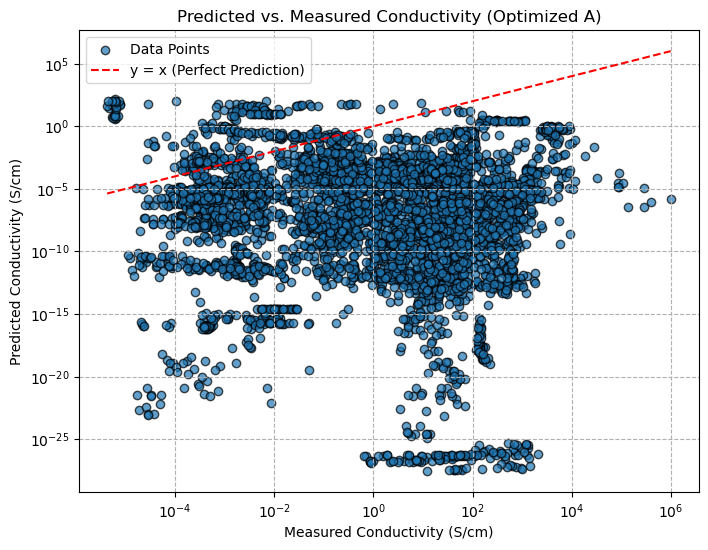

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Constants
k_B = 8.617e-5  # Boltzmann constant in eV/K

# Function to model the electrical conductivity based on the bandgap and parameter A
def conductivity_model(bandgap, temperature, A):
    return A * temperature**(-1.5) * np.exp(-bandgap / (2 * k_B * temperature))

# Objective function to minimize: sum of squared differences between measured and calculated conductivities
def objective_function(A, bandgaps, temperatures, measured_conductivities):
    calculated_conductivities = conductivity_model(bandgaps, temperatures, A)
    return np.sum((measured_conductivities - calculated_conductivities)**2)

# Ensure required columns are present
if 'opt_direct_bandgap' in combined_libraries_data_df.columns and 'absolute_temp_c' in combined_libraries_data_df.columns and 'fpm_conductivity' in combined_libraries_data_df.columns:
    # Filter rows with non-null values in the required columns
    filtered_data = combined_libraries_data_df[['opt_direct_bandgap', 'absolute_temp_c', 'fpm_conductivity']].dropna()

    # Convert temperature to Kelvin
    filtered_data['absolute_temp_k'] = filtered_data['absolute_temp_c'] + 273.15

    # Extract measured conductivity, bandgap, and temperature
    measured_conductivities = filtered_data['fpm_conductivity'].values
    bandgaps = filtered_data['opt_direct_bandgap'].values
    temperatures = filtered_data['absolute_temp_k'].values

    # Ensure valid values (positive conductivities and bandgaps)
    valid_indices = (measured_conductivities > 0) & (bandgaps > 0) & (temperatures > 0)
    measured_conductivities = measured_conductivities[valid_indices]
    bandgaps = bandgaps[valid_indices]
    temperatures = temperatures[valid_indices]

    # Define initial guess for A
    initial_A = 1e20

    # Minimize the objective function
    result = minimize(
        objective_function,
        initial_A,
        args=(bandgaps, temperatures, measured_conductivities),
        method='Nelder-Mead'
    )

    # Extract the optimized value of A
    optimized_A = result.x[0]
    print(f"Optimized value of A: {optimized_A}")

    # Calculate predicted conductivities using the optimized A
    predicted_conductivities = conductivity_model(bandgaps, temperatures, optimized_A)

    # Plot predicted vs. measured conductivity
    plt.figure(figsize=(8, 6))
    plt.scatter(measured_conductivities, predicted_conductivities, alpha=0.7, edgecolors='k', label="Data Points")
    plt.plot([measured_conductivities.min(), measured_conductivities.max()],
             [measured_conductivities.min(), measured_conductivities.max()],
             color='red', linestyle='--', label="y = x (Perfect Prediction)")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Measured Conductivity (S/cm)')
    plt.ylabel('Predicted Conductivity (S/cm)')
    plt.title('Predicted vs. Measured Conductivity (Optimized A)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
else:
    print("The required columns ('opt_direct_bandgap', 'absolute_temp_c', 'fpm_conductivity') are not present in the DataFrame.")


In [ ]:
#Is the bandgap incorrect? Let's examine the optical property data to check:

### Optical Transmittance Heatmap

This code visualizes optical transmittance data:

1. **Data Preparation**:
   - Filters rows with valid wavelength and normalized transmittance data.
   - Normalizes transmittance values to the range [0, 1].

2. **Interpolation**:
   - Aligns all transmittance data to a common wavelength grid for consistency.

3. **Heatmap**:
   - Displays normalized transmittance as a heatmap, with wavelength on the x-axis and sample index on the y-axis.

This visualization highlights patterns in transmittance across samples.


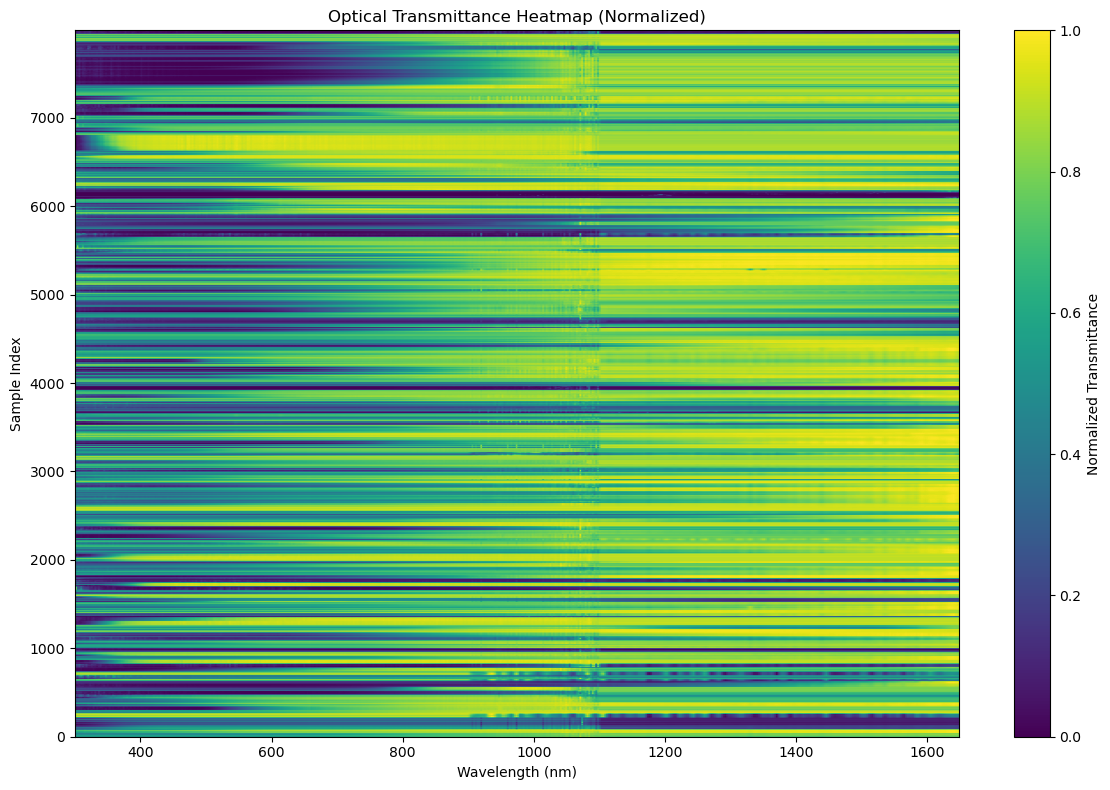

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out rows with valid data
valid_data = combined_libraries_data_df[
    combined_libraries_data_df['opt_wavelength'].notna() &
    combined_libraries_data_df['opt_normalized_transmittance'].notna()
]

# Ensure there are valid rows to plot
if not valid_data.empty:
    # Initialize lists to store heatmap data
    wavelength_grid = []
    transmittance_grid = []
    
    # Loop through the valid data to prepare the heatmap
    for idx, row in valid_data.iterrows():
        wavelengths = row['opt_wavelength']
        transmittances = row['opt_normalized_transmittance']
        
        # Skip if data lengths do not match or are empty
        if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
            # Normalize transmittance to range [0, 1]
            transmittances = (transmittances - np.min(transmittances)) / (np.max(transmittances) - np.min(transmittances))
            wavelength_grid.append(wavelengths)
            transmittance_grid.append(transmittances)
    
    # Create a uniform wavelength grid for the heatmap
    common_wavelengths = np.linspace(min(np.min(w) for w in wavelength_grid),
                                     max(np.max(w) for w in wavelength_grid),
                                     500)  # Set the resolution of the wavelength grid
    
    # Interpolate transmittance data to match the common wavelength grid
    interpolated_transmittance = []
    for wavelengths, transmittances in zip(wavelength_grid, transmittance_grid):
        interpolated_transmittance.append(
            np.interp(common_wavelengths, wavelengths, transmittances)
        )
    
    # Convert to a numpy array for plotting
    heatmap_data = np.array(interpolated_transmittance)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(heatmap_data, aspect='auto', extent=[common_wavelengths[0], common_wavelengths[-1], 0, len(heatmap_data)],
               cmap='viridis', origin='lower')
    plt.colorbar(label='Normalized Transmittance')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Sample Index')
    plt.title('Optical Transmittance Heatmap (Normalized)')
    plt.tight_layout()
    plt.show()
else:
    print("No valid optical data to plot.")


### Optical Transmittance Scatter Plots

This code visualizes normalized optical transmittance data for up to 20 samples:

1. **Data Preparation**:
   - Filters and normalizes transmittance data for valid samples.

2. **Visualization**:
   - Creates scatter plots of transmittance vs. wavelength for each sample in a grid layout.

This provides a detailed view of transmittance trends across individual samples.


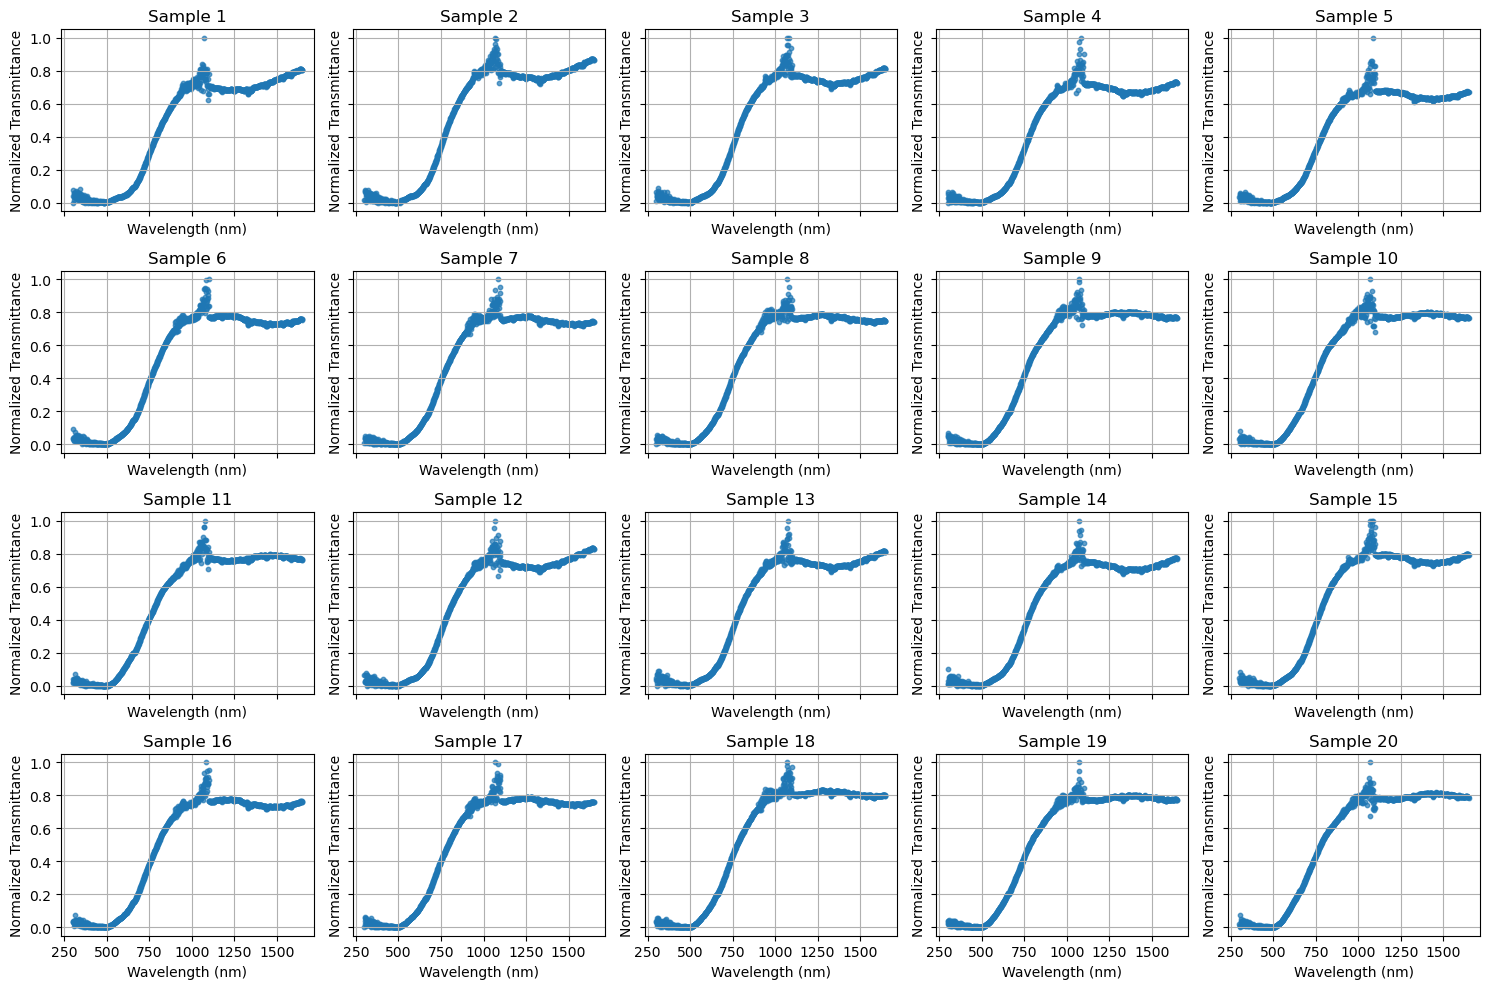

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out rows with valid data
valid_data = combined_libraries_data_df[
    combined_libraries_data_df['opt_wavelength'].notna() &
    combined_libraries_data_df['opt_normalized_transmittance'].notna()
]

# Ensure there are valid rows to plot
if not valid_data.empty:
    # Initialize lists to store data
    wavelength_grid = []
    transmittance_grid = []
    
    # Loop through the valid data to prepare the data
    for idx, row in valid_data.iterrows():
        wavelengths = row['opt_wavelength']
        transmittances = row['opt_normalized_transmittance']
        
        # Skip if data lengths do not match or are empty
        if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
            # Normalize transmittance to range [0, 1]
            transmittances = (transmittances - np.min(transmittances)) / (np.max(transmittances) - np.min(transmittances))
            wavelength_grid.append(wavelengths)
            transmittance_grid.append(transmittances)
    
    # Select 20 samples for visualization
    num_samples = 20
    samples_to_plot = min(num_samples, len(wavelength_grid))
    
    # Create a grid of plots
    fig, axes = plt.subplots(4, 5, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.ravel()  # Flatten axes for easy iteration

    for i in range(samples_to_plot):
        ax = axes[i]
        ax.scatter(wavelength_grid[i], transmittance_grid[i], s=10, alpha=0.7, label=f'Sample {i+1}')
        ax.set_title(f'Sample {i+1}')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Normalized Transmittance')
        ax.grid(True)

    # Hide any unused subplots
    for i in range(samples_to_plot, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No valid optical data to plot.")


In [ ]:
### Update clustering below to use dbi metric to identify ideal number of clusters

# Clustering Optical Transmittance Data

This code clusters optical transmittance data to identify representative samples from the dataset. Here's why this approach is valuable:

1. **Data Standardization**:
   - Ensures consistent comparison by interpolating transmittance data onto a common wavelength grid and scaling it for clustering.

2. **Clustering with KMeans**:
   - Groups similar transmittance profiles into 20 clusters, allowing patterns and trends in the data to emerge.

3. **Representative Samples**:
   - Selects one representative sample from each cluster, reducing the dataset while retaining diversity.

4. **Visualization**:
   - Scatter plots of representative transmittance profiles provide a concise overview of the key trends across clusters.

5. **Output**:
   - Provides a DataFrame of representative samples for further analysis.

This approach simplifies large datasets by focusing on diverse, representative samples, making it easier to analyze and interpret optical transmittance trends.


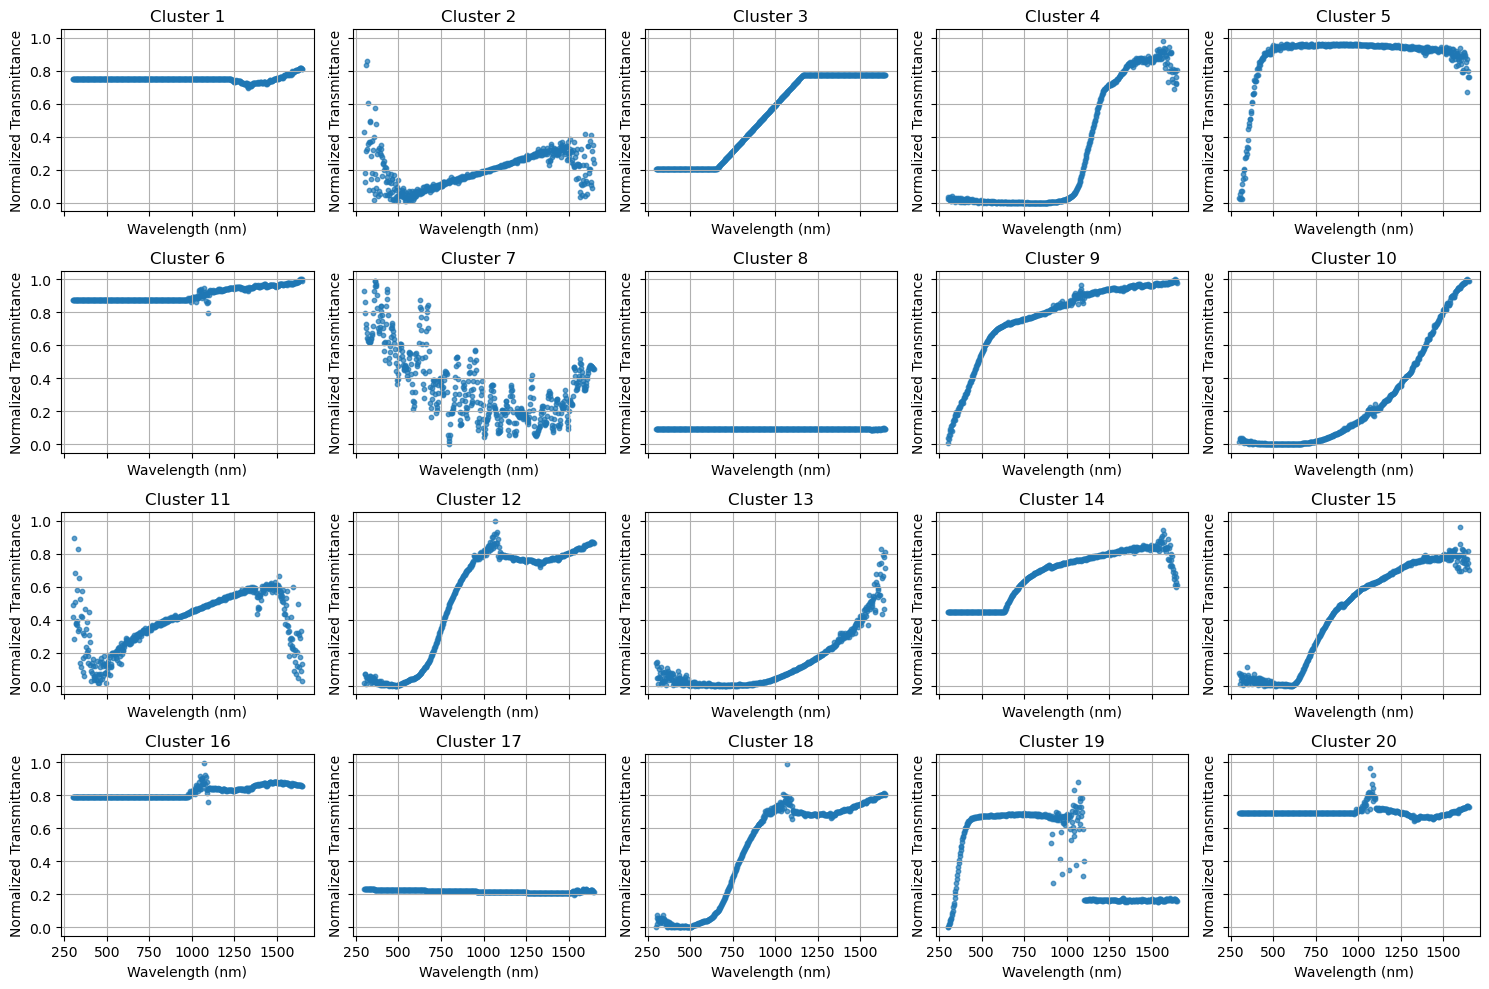

          id   num pdac  quality  person_id               sample_date  \
2     212252    34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
1919  209754   568    3      3.0       32.0                      None   
18    212270    34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
1685  228526   230    4      3.0       53.0  2013-10-14T00:00:00.000Z   
1466  219884   571    3      3.0       32.0                      None   
92    234893   813    1      3.0        NaN  2010-08-02T00:00:00.000Z   
761   214503   417    4      4.0       32.0                      None   
484   223251  1326    1      3.0        NaN  2012-06-05T00:00:00.000Z   
88    234890   813    1      3.0        NaN  2010-08-02T00:00:00.000Z   
1772  215673   253    4      3.0       52.0  2014-07-25T00:00:00.000Z   
1492  219880   571    3      3.0       32.0                      None   
1     212253    34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
1640  222322   224    4      3.0       52.0        

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Filter out rows with valid data
valid_data = combined_libraries_data_df[
    combined_libraries_data_df['opt_wavelength'].notna() &
    combined_libraries_data_df['opt_normalized_transmittance'].notna()
].copy()

# Ensure there are valid rows to process
if not valid_data.empty:
    # Initialize lists to store data
    feature_matrix = []
    original_indices = []

    # Loop through the valid data to prepare the data
    for idx, row in valid_data.iterrows():
        wavelengths = row['opt_wavelength']
        transmittances = row['opt_normalized_transmittance']
        
        # Skip if data lengths do not match or are empty
        if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
            # Normalize transmittance to range [0, 1]
            transmittances = (transmittances - np.min(transmittances)) / (np.max(transmittances) - np.min(transmittances))
            
            # Interpolate transmittances to a common wavelength grid
            common_wavelengths = np.linspace(min(wavelengths), max(wavelengths), 500)
            interpolated_transmittances = np.interp(common_wavelengths, wavelengths, transmittances)
            
            feature_matrix.append(interpolated_transmittances)
            original_indices.append(idx)

    # Convert the feature matrix to a numpy array
    feature_matrix = np.array(feature_matrix)

    # Standardize the feature matrix for clustering
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)

    # Perform KMeans clustering to identify 20 categories
    n_clusters = 20
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix_scaled)

    # Add cluster labels to valid_data
    valid_data['cluster'] = -1
    for idx, cluster_label in zip(original_indices, cluster_labels):
        valid_data.at[idx, 'cluster'] = cluster_label

    # Select one sample from each cluster
    representative_samples = []
    representative_indices = []
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:
            representative_indices.append(original_indices[cluster_indices[0]])  # Take the first sample in the cluster
            wavelengths = common_wavelengths
            transmittances = feature_matrix[cluster_indices[0]]
            representative_samples.append((wavelengths, transmittances))

    # Create a DataFrame for representative samples
    representative_samples_df = valid_data.loc[representative_indices].copy()

    # Plot representative samples
    fig, axes = plt.subplots(4, 5, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.ravel()  # Flatten axes for easy iteration

    for i, (wavelengths, transmittances) in enumerate(representative_samples):
        ax = axes[i]
        ax.scatter(wavelengths, transmittances, s=10, alpha=0.7, label=f'Cluster {i+1}')
        ax.set_title(f'Cluster {i+1}')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Normalized Transmittance')
        ax.grid(True)

    # Hide any unused subplots
    for i in range(len(representative_samples), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Output representative samples DataFrame
    print(representative_samples_df)
else:
    print("No valid optical data to process.")


In [30]:
# Isolate rows with valid data
valid_data = combined_libraries_data_df[
    combined_libraries_data_df['opt_wavelength'].notna() &
    combined_libraries_data_df['opt_normalized_transmittance'].notna()
].copy()

# Optical Transmittance Heatmap

This code visualizes normalized optical transmittance data:

1. **Preparation**: Filters valid data and normalizes transmittance to [0, 1].
2. **Interpolation**: Aligns transmittance data to a uniform wavelength grid.
3. **Heatmap**: Plots a 2D heatmap with wavelengths (x-axis), sample indices (y-axis), and transmittance intensity (color scale).
4. **Visualization**: Adds labels, a color bar, and a title to highlight patterns.

Displays a message if no valid data is available.


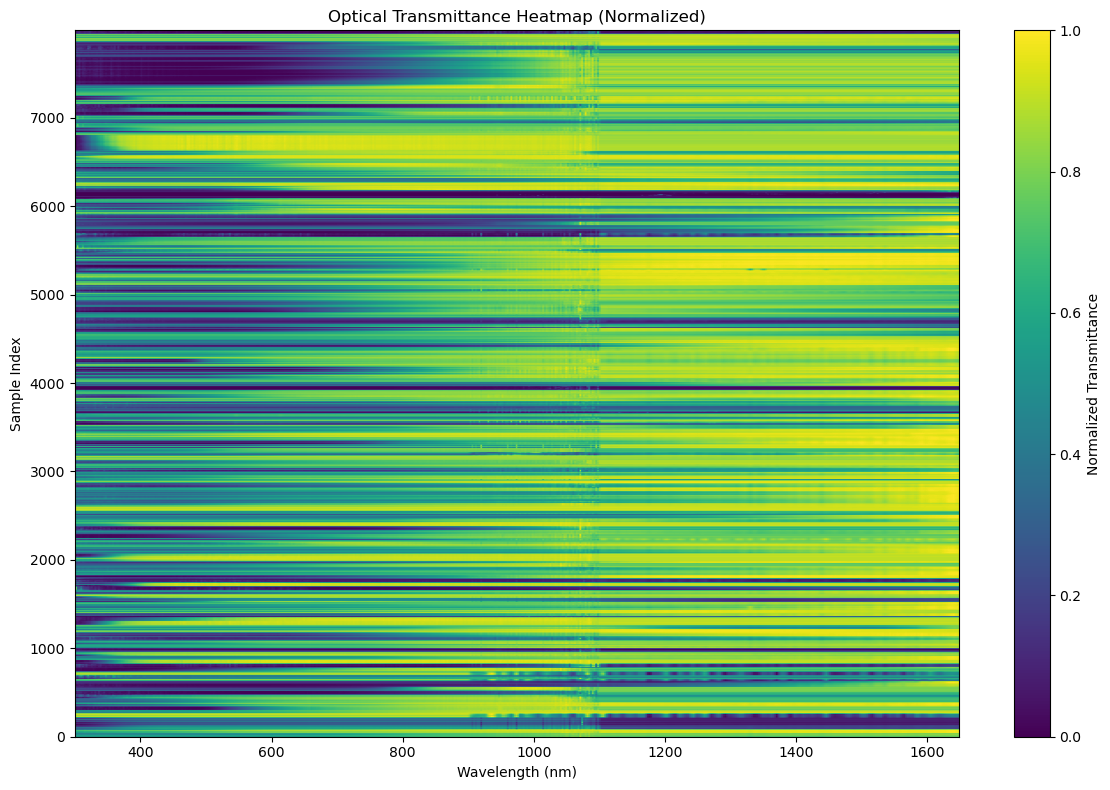

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure there are valid rows to plot
if not valid_data.empty:
    # Initialize lists to store heatmap data
    wavelength_grid = []
    transmittance_grid = []
    
    # Loop through the valid data to prepare the heatmap
    for idx, row in valid_data.iterrows():
        wavelengths = row['opt_wavelength']
        transmittances = row['opt_normalized_transmittance']
        
        # Skip if data lengths do not match or are empty
        if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
            # Normalize transmittance to range [0, 1]
            transmittances = (transmittances - np.min(transmittances)) / (np.max(transmittances) - np.min(transmittances))
            wavelength_grid.append(wavelengths)
            transmittance_grid.append(transmittances)
    
    # Create a uniform wavelength grid for the heatmap
    common_wavelengths = np.linspace(min(np.min(w) for w in wavelength_grid),
                                     max(np.max(w) for w in wavelength_grid),
                                     500)  # Set the resolution of the wavelength grid
    
    # Interpolate transmittance data to match the common wavelength grid
    interpolated_transmittance = []
    for wavelengths, transmittances in zip(wavelength_grid, transmittance_grid):
        interpolated_transmittance.append(
            np.interp(common_wavelengths, wavelengths, transmittances)
        )
    
    # Convert to a numpy array for plotting
    heatmap_data = np.array(interpolated_transmittance)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(heatmap_data, aspect='auto', extent=[common_wavelengths[0], common_wavelengths[-1], 0, len(heatmap_data)],
               cmap='viridis', origin='lower')
    plt.colorbar(label='Normalized Transmittance')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Sample Index')
    plt.title('Optical Transmittance Heatmap (Normalized)')
    plt.tight_layout()
    plt.show()
else:
    print("No valid optical data to plot.")


# Truncated Optical Transmittance Heatmap

This code enhances the heatmap by:

1. **Truncation**: Limits data to wavelengths ≤ 1000 nm, focusing on a relevant spectral range.
2. **Improved Visualization**: Adjusts the wavelength grid to the truncated range for consistent interpolation.

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure there are valid rows to plot
if not valid_data.empty:
    # Initialize lists to store truncated and normalized data
    wavelength_grid = []
    transmittance_grid = []
    
    # Loop through the valid data to prepare the heatmap
    for idx, row in valid_data.iterrows():
        wavelengths = np.array(row['opt_wavelength'])
        transmittances = np.array(row['opt_normalized_transmittance'])
        
        # Skip if data lengths do not match or are empty
        if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
            # Truncate data to a maximum wavelength of 1000 nm
            mask = wavelengths <= 1000
            truncated_wavelengths = wavelengths[mask]
            truncated_transmittances = transmittances[mask]
            
            # Normalize transmittance to range [0, 1]
            if len(truncated_transmittances) > 0:
                normalized_transmittances = (truncated_transmittances - np.min(truncated_transmittances)) / \
                                             (np.max(truncated_transmittances) - np.min(truncated_transmittances))
                wavelength_grid.append(truncated_wavelengths)
                transmittance_grid.append(normalized_transmittances)
    
    # Create a uniform wavelength grid for the heatmap
    common_wavelengths = np.linspace(300, 1000, 500)  # Adjust resolution to match truncated range
    
    # Interpolate transmittance data to match the common wavelength grid
    interpolated_transmittance = []
    for wavelengths, transmittances in zip(wavelength_grid, transmittance_grid):
        interpolated_transmittance.append(
            np.interp(common_wavelengths, wavelengths, transmittances)
        )
    
    # Convert to a numpy array for plotting
    heatmap_data = np.array(interpolated_transmittance)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(heatmap_data, aspect='auto', extent=[common_wavelengths[0], common_wavelengths[-1], 0, len(heatmap_data)],
               cmap='viridis', origin='lower')
    plt.colorbar(label='Normalized Transmittance')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Sample Index')
    plt.title('Optical Transmittance Heatmap (Normalized, Truncated to ≤ 1000 nm)')
    plt.tight_layout()
    plt.show()
else:
    print("No valid optical data to plot.")


In [ ]:
#artefacts present in data from 900-1000 nm. Let's truncate to <900 nm.

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure there are valid rows to plot
if not valid_data.empty:
    # Initialize lists to store truncated and normalized data
    wavelength_grid = []
    transmittance_grid = []
    
    # Loop through the valid data to prepare the heatmap
    for idx, row in valid_data.iterrows():
        wavelengths = np.array(row['opt_wavelength'])
        transmittances = np.array(row['opt_normalized_transmittance'])
        
        # Skip if data lengths do not match or are empty
        if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
            # Truncate data to a maximum wavelength of 900 nm
            mask = wavelengths <= 900
            truncated_wavelengths = wavelengths[mask]
            truncated_transmittances = transmittances[mask]
            
            # Normalize transmittance to range [0, 1]
            if len(truncated_transmittances) > 0:
                trans_min = np.min(truncated_transmittances)
                trans_max = np.max(truncated_transmittances)
                if trans_max > trans_min:
                    normalized_transmittances = (truncated_transmittances - trans_min) / (trans_max - trans_min)
                else:
                    normalized_transmittances = np.zeros_like(truncated_transmittances)
                
                wavelength_grid.append(truncated_wavelengths)
                transmittance_grid.append(normalized_transmittances)
    
    # Create a uniform wavelength grid for the heatmap
    common_wavelengths = np.linspace(300, 900, 500)  # Adjust resolution to match truncated range
    
    # Interpolate transmittance data to match the common wavelength grid
    interpolated_transmittance = []
    for wavelengths, transmittances in zip(wavelength_grid, transmittance_grid):
        interpolated_transmittance.append(
            np.interp(common_wavelengths, wavelengths, transmittances)
        )
    
    # Convert to a numpy array for plotting
    heatmap_data = np.array(interpolated_transmittance)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(heatmap_data, aspect='auto', extent=[common_wavelengths[0], common_wavelengths[-1], 0, len(heatmap_data)],
               cmap='viridis', origin='lower')
    plt.colorbar(label='Normalized Transmittance')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Sample Index')
    plt.title('Optical Transmittance Heatmap (Normalized, Truncated to ≤ 900 nm)')
    plt.tight_layout()
    plt.show()
else:
    print("No valid optical data to plot.")


In [57]:
# Filter out rows with valid data
valid_data = representative_samples_df[
    representative_samples_df['opt_wavelength'].notna() &
    representative_samples_df['opt_normalized_transmittance'].notna() &
    representative_samples_df['thickness'].notna()
].copy()

## Tauc Plot Analysis for Bandgap Estimation

This code estimates bandgaps from optical transmittance data by:

1. Converting wavelengths to photon energy (eV).
2. Calculating \((\alpha h\nu)^2\) from transmittance.
3. Using Tauc plots and linear fits to estimate bandgaps.
4. Plotting up to 20 samples with bandgap values and fits.
5. Calculating the average bandgap across samples.

C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\scipy\stats\_stats_py.py:10919: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\scipy\stats\_stats_py.py:10933: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\scipy\stats\_stats_py.py:10936: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\2524564595.py:54: RankWarning: Polyfit may be poorly conditioned
  ax.plot(energy, np.polyval(np.polyfit(energy, alpha_hnu_2, 1), energy), label='Linear Fit', color='red')


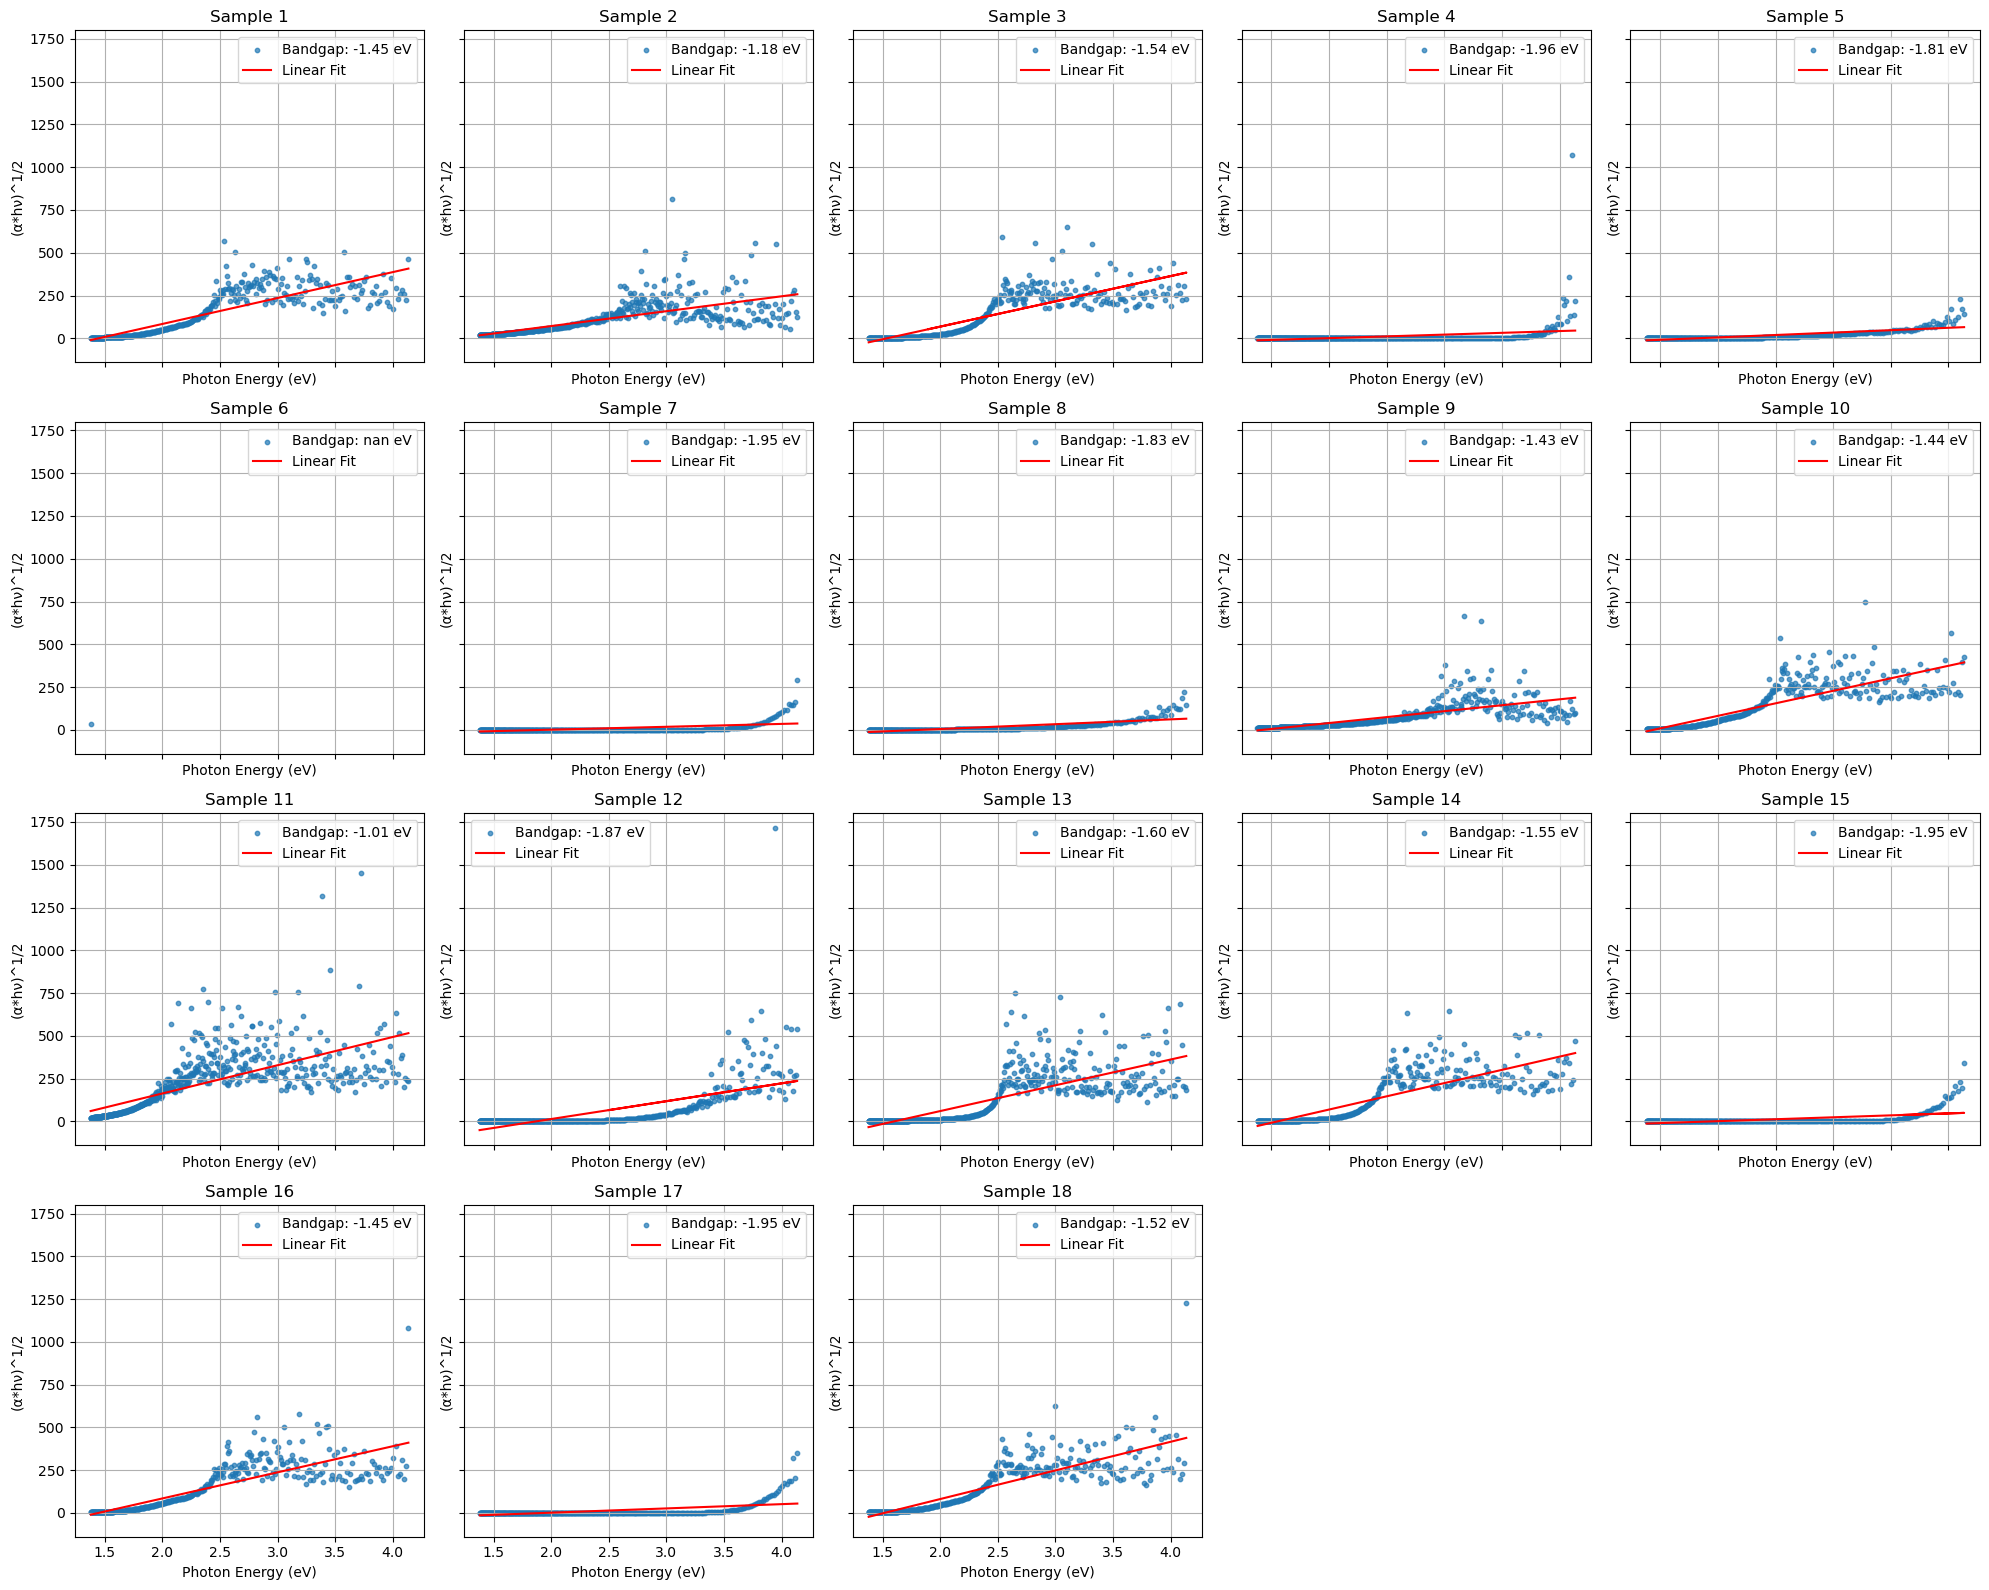

Average Bandgap (Direct): -1.62 eV


In [58]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Function for Tauc Analysis
def tauc_analysis(wavelengths, transmittances, thickness=1):
    # Convert wavelength (nm) to energy (eV): E = hc/λ
    h = 6.62607015e-34  # Planck's constant in J.s
    c = 3e8  # Speed of light in m/s
    eV_conversion = 1.60218e-19  # Joules to eV
    energy = (h * c) / (wavelengths * 1e-9)  # Energy in Joules, convert to eV
    energy = energy / eV_conversion  # Energy in eV

    # Calculate absorption coefficient (α) from transmittance data
    # Assume a thickness of 1 nm for simplicity if not provided
    alpha = -np.log(transmittances) / thickness

    # Calculate (α * hν)^2 for Tauc plot
    alpha_hnu_2 = (alpha * energy)**2  # (α*hν)^2
    
    # Perform linear fitting
    slope, intercept, r_value, p_value, std_err = stats.linregress(energy, alpha_hnu_2)

    # Estimate the bandgap from the x-intercept of the linear fit
    bandgap = intercept / slope  # Where the line crosses the x-axis (energy)
    
    return bandgap, energy, alpha_hnu_2

# Prepare for grid plotting
fig, axes = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=True)
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Prepare data for Tauc analysis
bandgaps = []
for idx, (row, ax) in enumerate(zip(valid_data.iterrows(), axes)):
    row = row[1]  # Extract the actual row data
    wavelengths = np.array(row['opt_wavelength'])
    transmittances = np.array(row['opt_normalized_transmittance'])
    
    # Skip if data lengths do not match or are empty
    if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
        # Truncate data to a maximum wavelength of 900 nm
        mask = wavelengths <= 900
        truncated_wavelengths = wavelengths[mask]
        truncated_transmittances = transmittances[mask]
        
        # Perform Tauc analysis
        try:
            bandgap, energy, alpha_hnu_2 = tauc_analysis(truncated_wavelengths, truncated_transmittances)
            bandgaps.append(bandgap)
            
            # Plot in the corresponding subplot
            ax.scatter(energy, alpha_hnu_2, s=10, alpha=0.7, label=f'Bandgap: {bandgap:.2f} eV')
            ax.plot(energy, np.polyval(np.polyfit(energy, alpha_hnu_2, 1), energy), label='Linear Fit', color='red')
            ax.set_title(f'Sample {idx + 1}')
            ax.set_xlabel('Photon Energy (eV)')
            ax.set_ylabel('(α*hν)^1/2')
            ax.legend()
            ax.grid(True)
        except Exception as e:
            ax.text(0.5, 0.5, 'Error in processing', ha='center', va='center', transform=ax.transAxes)

# Hide any unused subplots
for i in range(len(valid_data), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate the average bandgap (if needed)
avg_bandgap = np.nanmean(bandgaps)  # Handle potential NaN values
print(f'Average Bandgap (Direct): {avg_bandgap:.2f} eV')


# Improvement with Thickness Inclusion

This updated code enhances bandgap estimation by incorporating **sample-specific thickness** data to calculate the absorption coefficient $(\alpha)$ accurately.



In [59]:

#can you update this script to include the thickness from valid_data
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Function for Tauc Analysis
def tauc_analysis(wavelengths, transmittances, thickness_um):
    # Convert thickness from micrometers to meters
    thickness_m = thickness_um * 1e-6  # Convert μm to m

    # Convert wavelength (nm) to energy (eV): E = hc/λ
    h = 6.62607015e-34  # Planck's constant in J·s
    c = 3e8  # Speed of light in m/s
    eV_conversion = 1.60218e-19  # Joules to eV
    energy = (h * c) / (wavelengths * 1e-9)  # Energy in Joules, convert to eV
    energy = energy / eV_conversion  # Energy in eV

    # Calculate absorption coefficient (α) from transmittance data
    alpha = -np.log(transmittances) / thickness_m

    # Calculate (α * hν)^2 for Tauc plot
    alpha_hnu_2 = (alpha * energy)**2  # (α*hν)^2

    # Linear fitting of the (α*hν)^1/2 vs hν curve
    slope, intercept, r_value, p_value, std_err = stats.linregress(energy, alpha_hnu_2)

    # Estimate the bandgap from the x-intercept of the linear fit
    bandgap = -intercept / slope  # Where the line crosses the x-axis (energy)

    return bandgap, energy, alpha_hnu_2

# Prepare data for Tauc analysis and grid plotting
fig, axes = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=True)
axes = axes.ravel()  # Flatten the 2D array for easy iteration

bandgaps = []
for idx, (row, ax) in enumerate(zip(valid_data.iterrows(), axes)):
    row = row[1]  # Extract the actual row data
    wavelengths = np.array(row['opt_wavelength'])
    transmittances = np.array(row['opt_normalized_transmittance'])
    thickness_um = row['thickness']  # Sample thickness in μm

    # Skip if data lengths do not match or are empty
    if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
        # Truncate data to a maximum wavelength of 900 nm
        mask = wavelengths <= 900
        truncated_wavelengths = wavelengths[mask]
        truncated_transmittances = transmittances[mask]

        try:
            # Perform Tauc analysis
            bandgap, energy, alpha_hnu_2 = tauc_analysis(truncated_wavelengths, truncated_transmittances, thickness_um)
            bandgaps.append(bandgap)

            # Plot in the grid
            ax.scatter(energy, alpha_hnu_2, s=10, alpha=0.7, label=f'Bandgap: {bandgap:.2f} eV')
            ax.plot(energy, np.polyval(np.polyfit(energy, alpha_hnu_2, 1), energy), color='red', label='Linear Fit')
            ax.set_title(f'Sample {idx + 1} (Thickness: {thickness_um:.2f} μm)')
            ax.set_xlabel('Photon Energy (eV)')
            ax.set_ylabel('(α*hν)^1/2')
            ax.legend()
            ax.grid(True)
        except Exception as e:
            ax.text(0.5, 0.5, 'Error in processing', ha='center', va='center', transform=ax.transAxes)

# Hide unused subplots if valid_data has fewer than 20 rows
for i in range(len(valid_data), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Calculate the average bandgap
avg_bandgap = np.nanmean(bandgaps)  # Handle potential NaN values
print(f'Average Bandgap (Direct): {avg_bandgap:.2f} eV')



C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\3454314846.py:19: RuntimeWarning: divide by zero encountered in divide
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\3454314846.py:57: RankWarning: Polyfit may be poorly conditioned
  ax.plot(energy, np.polyval(np.polyfit(energy, alpha_hnu_2, 1), energy), color='red', label='Linear Fit')


Average Bandgap (Direct): 1.60 eV


## Improved Tauc Analysis with Linear Region Optimization

This code refines bandgap estimation by dynamically identifying the optimal linear region for Tauc plots, minimizing error within a sliding 0.5 eV energy window. This ensures more accurate bandgap calculations tailored to each sample's data, improving reliability over a fixed region approach.


In [60]:

#update this code to determine the linear region for tauc analysis for each plot by finding the range in energy of 0.5 eV width that produces the lowest error from a linear fit:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Function for Tauc Analysis with optimized linear region fitting
def tauc_analysis(wavelengths, transmittances, thickness_um):
    # Convert thickness from micrometers to meters
    thickness_m = thickness_um * 1e-6  # Convert μm to m

    # Convert wavelength (nm) to energy (eV): E = hc/λ
    h = 6.62607015e-34  # Planck's constant in J·s
    c = 3e8  # Speed of light in m/s
    eV_conversion = 1.60218e-19  # Joules to eV
    energy = (h * c) / (wavelengths * 1e-9) / eV_conversion  # Energy in eV

    # Calculate absorption coefficient (α) from transmittance data
    alpha = -np.log(transmittances) / thickness_m

    # Calculate (α * hν)^2 for Tauc plot
    alpha_hnu_2 = (alpha * energy)**2  # (α*hν)^2

    # Initialize variables for the optimal linear region
    best_slope = None
    best_intercept = None
    best_metric = float('inf')  # Metric = error / abs(slope)
    best_bandgap = None

    # Define the window size and step size
    window_size = 0.3  # Energy range in eV
    step_size = 0.1  # Increment for moving the window

    # Search all possible 0.5 eV-wide windows
    min_energy = np.min(energy)
    max_energy = np.max(energy)

    for start in np.arange(min_energy, max_energy - window_size, step_size):
        end = start + window_size
        mask = (energy >= start) & (energy <= end)
        if np.sum(mask) >= 2:  # At least 2 points required for fitting
            slope, intercept, _, _, _ = linregress(energy[mask], alpha_hnu_2[mask])
            error = np.mean((alpha_hnu_2[mask] - (slope * energy[mask] + intercept)) ** 2)
            if slope > 0:
                metric = error**2 / slope**5
                if metric < best_metric:
                    best_metric = metric
                    best_slope = slope
                    best_intercept = intercept
                    best_bandgap = -intercept / slope  # Bandgap from x-intercept

    return best_bandgap, energy, alpha_hnu_2, best_slope, best_intercept

# Initialize a new column for calculated bandgap
valid_data['calc_tauc_direct_bandgap_eV'] = np.nan

# Prepare data for Tauc analysis and grid plotting
fig, axes = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=True)
axes = axes.ravel()  # Flatten the 2D array for easier iteration

for idx, (row, ax) in enumerate(zip(valid_data.iterrows(), axes)):
    row = row[1]  # Extract the actual row data
    wavelengths = np.array(row['opt_wavelength'])
    transmittances = np.array(row['opt_normalized_transmittance'])
    thickness_um = row['thickness']  # Sample thickness in μm

    # Skip if data lengths do not match or are empty
    if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
        # Truncate data to a maximum wavelength of 900 nm
        mask = wavelengths <= 900
        truncated_wavelengths = wavelengths[mask]
        truncated_transmittances = transmittances[mask]

        try:
            # Perform Tauc analysis
            bandgap, energy, alpha_hnu_2, best_slope, best_intercept = tauc_analysis(
                truncated_wavelengths, truncated_transmittances, thickness_um
            )
            valid_data.at[idx, 'calc_tauc_direct_bandgap_eV'] = bandgap

            # Plot in the grid
            ax.scatter(energy, alpha_hnu_2, s=10, alpha=0.7, label=f'Bandgap: {bandgap:.2f} eV' if bandgap else 'N/A')
            if best_slope is not None:
                linear_fit = best_slope * energy + best_intercept
                ax.plot(energy, linear_fit, color='red', label='Optimal Linear Fit')
            ax.set_title(f'Sample {idx + 1} (Thickness: {thickness_um:.2f} μm)')
            ax.set_xlabel('Photon Energy (eV)')
            ax.set_ylabel('(α*hν)^2')
            ax.legend()
            ax.grid(True)
        except Exception as e:
            ax.text(0.5, 0.5, 'Error', ha='center', va='center', transform=ax.transAxes)

# Hide unused subplots if valid_data has fewer than 20 rows
for i in range(len(valid_data), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Display summary of bandgap results
print(valid_data[['calc_tauc_direct_bandgap_eV']].describe())


C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\1698528753.py:18: RuntimeWarning: divide by zero encountered in divide
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


       calc_tauc_direct_bandgap_eV
count                    16.000000
mean                      2.050231
std                       0.874434
min                       1.064459
25%                       1.566450
50%                       1.697785
75%                       2.385281
max                       3.729072


In [16]:
# Isolate rows with valid data
valid_data = combined_libraries_data_df[
    combined_libraries_data_df['opt_wavelength'].notna() &
    combined_libraries_data_df['opt_normalized_transmittance'].notna() &
    combined_libraries_data_df['thickness'].notna()
].copy()

In [ ]:
#Now let's do this automated analysis for the full dataset!

In [64]:
import numpy as np
from scipy.stats import linregress
from tqdm.notebook import tqdm  # For Jupyter Notebook-compatible progress bar

# Function for Tauc Analysis with optimized linear region fitting
def tauc_analysis(wavelengths, transmittances, thickness_um):
    # Convert thickness from micrometers to meters
    thickness_m = thickness_um * 1e-6  # Convert μm to m

    # Convert wavelength (nm) to energy (eV): E = hc/λ
    h = 6.62607015e-34  # Planck's constant in J·s
    c = 3e8  # Speed of light in m/s
    eV_conversion = 1.60218e-19  # Joules to eV
    energy = (h * c) / (wavelengths * 1e-9) / eV_conversion  # Energy in eV

    # Calculate absorption coefficient (α) from transmittance data
    # α = -ln(T) / thickness
    alpha = -np.log(transmittances) / thickness_m

    # Calculate (α * hν)^2 for Tauc plot (direct bandgap)
    alpha_hnu_2 = (alpha * energy) ** 2  # (α*hν)^2

    # Initialize variables for the optimal linear region
    best_slope = None
    best_intercept = None
    best_metric = float('inf')  # Metric = error / abs(slope)
    best_bandgap = None

    # Define the window size and step size
    window_size = 0.3  # Energy range in eV
    step_size = 0.1  # Increment for moving the window

    # Search all possible 0.5 eV-wide windows
    min_energy = np.min(energy)
    max_energy = np.max(energy)

    for start in np.arange(min_energy, max_energy - window_size, step_size):
        end = start + window_size
        mask = (energy >= start) & (energy <= end)
        if np.sum(mask) >= 2:  # At least 2 points required for fitting
            slope, intercept, _, _, _ = linregress(energy[mask], alpha_hnu_2[mask])
            error = np.mean((alpha_hnu_2[mask] - (slope * energy[mask] + intercept)) ** 2)
            if slope > 0:
                metric = error**2 / slope**5
                if metric < best_metric:
                    best_metric = metric
                    best_slope = slope
                    best_intercept = intercept
                    best_bandgap = -intercept / slope  # Bandgap from x-intercept

    return best_bandgap

# Initialize a new column for calculated bandgap
valid_data['calc_tauc_direct_bandgap_eV'] = np.nan

# Prepare data for Tauc analysis
for idx, row in tqdm(valid_data.iterrows(), total=len(valid_data), desc="Processing Samples"):
    wavelengths = np.array(row['opt_wavelength'])
    transmittances = np.array(row['opt_normalized_transmittance'])
    thickness_um = row['thickness']  # Sample thickness in μm

    # Skip if data lengths do not match or are empty
    if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
        # Truncate data to a maximum wavelength of 900 nm
        mask = wavelengths <= 900
        truncated_wavelengths = wavelengths[mask]
        truncated_transmittances = transmittances[mask]

        try:
            # Perform Tauc analysis
            bandgap = tauc_analysis(truncated_wavelengths, truncated_transmittances, thickness_um)
            valid_data.at[idx, 'calc_tauc_direct_bandgap_eV'] = bandgap
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")

# Display summary of bandgap results
print(valid_data[['calc_tauc_direct_bandgap_eV']].describe())


Processing Samples:   0%|          | 0/6748 [00:00<?, ?it/s]

C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\455798285.py:18: RuntimeWarning: divide by zero encountered in log
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\455798285.py:18: RuntimeWarning: divide by zero encountered in divide
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\455798285.py:18: RuntimeWarning: divide by zero encountered in log
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\455798285.py:18: RuntimeWarning: divide by zero encountered in log
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d

       calc_tauc_direct_bandgap_eV
count                  6619.000000
mean                      2.081969
std                       0.770573
min                       0.461783
25%                       1.467445
50%                       1.940081
75%                       2.461978
max                       3.816775


In [ ]:
#While we're at it, let's also calculate the indirect bandgap

In [65]:
import numpy as np
from scipy.stats import linregress
from tqdm.notebook import tqdm  # For Jupyter Notebook-compatible progress bar

# Function for Tauc Analysis with optimized linear region fitting
def tauc_analysis(wavelengths, transmittances, thickness_um):
    # Convert thickness from micrometers to meters
    thickness_m = thickness_um * 1e-6  # Convert μm to m

    # Convert wavelength (nm) to energy (eV): E = hc/λ
    h = 6.62607015e-34  # Planck's constant in J·s
    c = 3e8  # Speed of light in m/s
    eV_conversion = 1.60218e-19  # Joules to eV
    energy = (h * c) / (wavelengths * 1e-9) / eV_conversion  # Energy in eV

    # Calculate absorption coefficient (α) from transmittance data
    # α = -ln(T) / thickness
    alpha = -np.log(transmittances) / thickness_m

    # Calculate (α * hν)^1/2 for Tauc plot (indirect bandgap)
    alpha_hnu_1_2 = np.sqrt(alpha * energy)  # (α*hν)^1/2

    # Initialize variables for the optimal linear region
    best_slope = None
    best_intercept = None
    best_metric = float('inf')  # Metric = error / abs(slope)
    best_bandgap = None

    # Define the window size and step size
    window_size = 0.3  # Energy range in eV
    step_size = 0.1  # Increment for moving the window

    # Search all possible 0.5 eV-wide windows
    min_energy = np.min(energy)
    max_energy = np.max(energy)

    for start in np.arange(min_energy, max_energy - window_size, step_size):
        end = start + window_size
        mask = (energy >= start) & (energy <= end)
        if np.sum(mask) >= 2:  # At least 2 points required for fitting
            slope, intercept, _, _, _ = linregress(energy[mask], alpha_hnu_1_2[mask])
            error = np.mean((alpha_hnu_1_2[mask] - (slope * energy[mask] + intercept)) ** 2)
            if slope > 0:
                metric = error**2 / slope**5
                if metric < best_metric:
                    best_metric = metric
                    best_slope = slope
                    best_intercept = intercept
                    best_bandgap = -intercept / slope  # Bandgap from x-intercept

    return best_bandgap

# Initialize a new column for calculated bandgap
valid_data['calc_tauc_indirect_bandgap_eV'] = np.nan

# Prepare data for Tauc analysis with progress bar
for idx, row in tqdm(valid_data.iterrows(), total=len(valid_data), desc="Processing Samples"):
    wavelengths = np.array(row['opt_wavelength'])
    transmittances = np.array(row['opt_normalized_transmittance'])
    thickness_um = row['thickness']  # Sample thickness in μm

    # Skip if data lengths do not match or are empty
    if len(wavelengths) == len(transmittances) and len(wavelengths) > 0:
        # Truncate data to a maximum wavelength of 900 nm
        mask = wavelengths <= 900
        truncated_wavelengths = wavelengths[mask]
        truncated_transmittances = transmittances[mask]

        try:
            # Perform Tauc analysis
            bandgap = tauc_analysis(truncated_wavelengths, truncated_transmittances, thickness_um)
            valid_data.at[idx, 'calc_tauc_indirect_bandgap_eV'] = bandgap
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")

# Display summary of bandgap results
print(valid_data[['calc_tauc_indirect_bandgap_eV']].describe())


Processing Samples:   0%|          | 0/6748 [00:00<?, ?it/s]

C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\1623252627.py:21: RuntimeWarning: invalid value encountered in sqrt
  alpha_hnu_1_2 = np.sqrt(alpha * energy)  # (α*hν)^1/2
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\1623252627.py:21: RuntimeWarning: invalid value encountered in sqrt
  alpha_hnu_1_2 = np.sqrt(alpha * energy)  # (α*hν)^1/2
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\1623252627.py:18: RuntimeWarning: divide by zero encountered in log
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d\Anaconda3\envs\ci\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\1623252627.py:18: RuntimeWarning: divide by zero encountered in divide
  alpha = -np.log(transmittances) / thickness_m
C:\Users\mjym8d\AppData\Local\Temp\ipykernel_29040\1623252627.py:18: RuntimeWarning: divide by zero encountered in log
  alpha = -np.log(transmittances) /

       calc_tauc_indirect_bandgap_eV
count                    6619.000000
mean                        1.225098
std                         1.004701
min                        -3.115375
25%                         0.730117
50%                         1.126512
75%                         1.622004
max                         3.524965


In [66]:
uncomment this line and run to save the combined DataFrame to a file for future use
if not valid_data.empty:
    output_file = "Filtered_Libraries_Data_wTauc.parquet"
    valid_data.to_parquet(output_file, engine='pyarrow', index=False)


In [17]:
import pandas as pd

# File path
input_file = "Filtered_Libraries_Data_wTauc.parquet"

# Read the parquet file
try:
    loaded_data = pd.read_parquet(input_file, engine='pyarrow')
    print("File successfully loaded!")
    print(loaded_data.head())  # Display the first few rows for verification
except FileNotFoundError:
    print(f"File {input_file} not found. Please ensure the file exists.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")


File successfully loaded!
       id  num pdac  quality  person_id               sample_date  \
0  212251   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
1  212253   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
2  212252   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
3  212255   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   
4  212254   34    4      3.0       52.0  2013-03-05T00:00:00.000Z   

          owner_name               owner_email xrf_type sputter_operator  ...  \
0  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
1  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
2  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
3  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   
4  Lauryn Baranowski  l.l.baranowski@gmail.com    maxxi             None  ...   

                                 opt_nirr_wavelength  \
0  [899.9, 901.6

In [18]:
valid_data=loaded_data

In [19]:
valid_data.keys()

Index(['id', 'num', 'pdac', 'quality', 'person_id', 'sample_date',
       'owner_name', 'owner_email', 'xrf_type', 'sputter_operator',
       'sample_ids', 'elements', 'xrf_elements', 'xrf_compounds',
       'deposition_sample_time_min', 'deposition_compounds',
       'deposition_power', 'deposition_base_pressure_mtorr',
       'deposition_growth_pressure_mtorr', 'deposition_target_pulses',
       'deposition_rep_rate', 'deposition_energy', 'deposition_cycles',
       'deposition_ts_distance', 'deposition_initial_temp_c', 'box_number',
       'deposition_gases', 'deposition_substrate_material',
       'deposition_gas_flow_sccm', 'has_xrd', 'has_xrf', 'has_ele', 'has_opt',
       'data_access', 'sample_library_id', 'position', 'thickness',
       'xrf_concentration', 'xrd_angle', 'xrd_background', 'xrd_intensity',
       'fpm_voltage_volts', 'fpm_current_amps', 'fpm_sheet_resistance',
       'fpm_standard_deviation', 'fpm_resistivity', 'fpm_conductivity',
       'absolute_temp_c', 'ele_

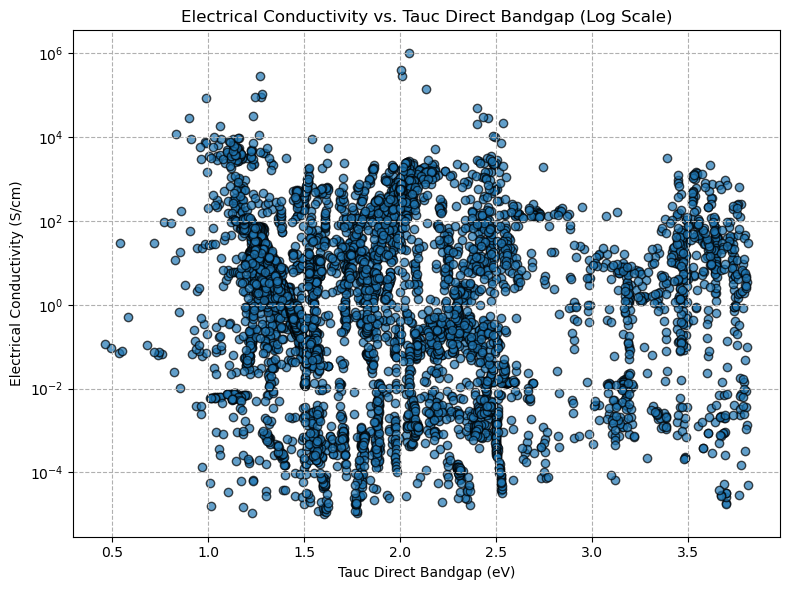

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Check if the necessary columns are in the DataFrame
if 'fpm_conductivity' in valid_data.columns and 'calc_tauc_direct_bandgap_eV' in valid_data.columns:
    # Extract non-null conductivity and bandgap data
    filtered_data = valid_data[['fpm_conductivity', 'calc_tauc_direct_bandgap_eV']].dropna()

    # Convert to numeric for plotting, handling potential non-numeric entries
    filtered_data['fpm_conductivity'] = pd.to_numeric(filtered_data['fpm_conductivity'], errors='coerce')
    filtered_data['calc_tauc_direct_bandgap_eV'] = pd.to_numeric(filtered_data['calc_tauc_direct_bandgap_eV'], errors='coerce')
    filtered_data = filtered_data.dropna()  # Drop rows with non-numeric data
    
    conductivities = filtered_data['fpm_conductivity']
    bandgaps = filtered_data['calc_tauc_direct_bandgap_eV']

    # Plotting the data with a log scale for the y-axis
    plt.figure(figsize=(8, 6))
    plt.scatter(bandgaps, conductivities, alpha=0.7, edgecolors='k')
    plt.xscale('linear')
    plt.yscale('log')  # Setting y-axis to logarithmic scale
    plt.xlabel('Tauc Direct Bandgap (eV)')
    plt.ylabel('Electrical Conductivity (S/cm)')
    plt.title('Electrical Conductivity vs. Tauc Direct Bandgap (Log Scale)')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
else:
    print("The required columns ('fpm_conductivity', 'calc_tauc_direct_bandgap_eV') are not present in the DataFrame.")


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Check if the necessary columns are in the DataFrame
if 'calc_tauc_direct_bandgap_eV' in valid_data.columns and 'opt_direct_bandgap' in valid_data.columns:
    # Extract non-null bandgap data
    filtered_data = valid_data[['calc_tauc_direct_bandgap_eV', 'opt_direct_bandgap']].dropna()

    # Convert to numeric for plotting, handling potential non-numeric entries
    filtered_data['calc_tauc_direct_bandgap_eV'] = pd.to_numeric(filtered_data['calc_tauc_direct_bandgap_eV'], errors='coerce')
    filtered_data['opt_direct_bandgap'] = pd.to_numeric(filtered_data['opt_direct_bandgap'], errors='coerce')
    filtered_data = filtered_data.dropna()  # Drop rows with non-numeric data
    
    tauc_bandgaps = filtered_data['calc_tauc_direct_bandgap_eV']
    opt_bandgaps = filtered_data['opt_direct_bandgap']

    # Plotting the data
    plt.figure(figsize=(8, 6))
    plt.scatter(opt_bandgaps, tauc_bandgaps, alpha=0.7, edgecolors='k')
    plt.xlabel('Optical Direct Bandgap (eV)')
    plt.ylabel('Tauc Direct Bandgap (eV)')
    plt.title('Tauc Direct Bandgap vs. Optical Direct Bandgap')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
else:
    print("The required columns ('calc_tauc_direct_bandgap_eV', 'opt_direct_bandgap') are not present in the DataFrame.")


Optimized value of A: 6428741428.156122


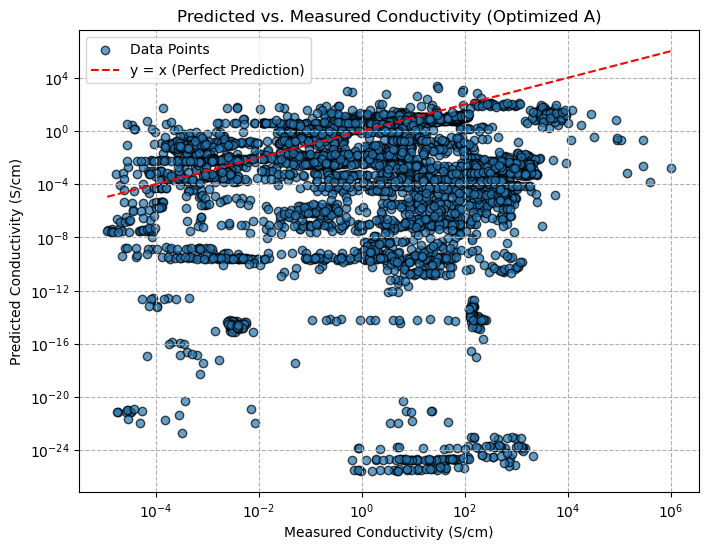

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Constants
k_B = 8.617e-5  # Boltzmann constant in eV/K

# Function to model the electrical conductivity based on the bandgap and parameter A
def conductivity_model(bandgap, temperature, A):
    return A * temperature**(-1.5) * np.exp(-bandgap / (2 * k_B * temperature))

# Objective function to minimize: sum of squared differences between measured and calculated conductivities
def objective_function(A, bandgaps, temperatures, measured_conductivities):
    calculated_conductivities = conductivity_model(bandgaps, temperatures, A)
    return np.sum((measured_conductivities - calculated_conductivities)**2)

# Ensure required columns are present
if 'calc_tauc_direct_bandgap_eV' in valid_data.columns and 'absolute_temp_c' in valid_data.columns and 'fpm_conductivity' in valid_data.columns:
    # Filter rows with non-null values in the required columns
    filtered_data = valid_data[['calc_tauc_direct_bandgap_eV', 'absolute_temp_c', 'fpm_conductivity']].dropna()

    # Convert temperature to Kelvin
    filtered_data['absolute_temp_k'] = filtered_data['absolute_temp_c'] + 273.15

    # Extract measured conductivity, bandgap, and temperature
    measured_conductivities = filtered_data['fpm_conductivity'].values
    bandgaps = filtered_data['calc_tauc_direct_bandgap_eV'].values
    temperatures = filtered_data['absolute_temp_k'].values

    # Ensure valid values (positive conductivities and bandgaps)
    valid_indices = (measured_conductivities > 0) & (bandgaps > 0) & (temperatures > 0)
    measured_conductivities = measured_conductivities[valid_indices]
    bandgaps = bandgaps[valid_indices]
    temperatures = temperatures[valid_indices]

    # Define initial guess for A
    initial_A = 1e20

    # Minimize the objective function
    result = minimize(
        objective_function,
        initial_A,
        args=(bandgaps, temperatures, measured_conductivities),
        method='Nelder-Mead'
    )

    # Extract the optimized value of A
    optimized_A = result.x[0]
    print(f"Optimized value of A: {optimized_A}")

    # Calculate predicted conductivities using the optimized A
    predicted_conductivities = conductivity_model(bandgaps, temperatures, optimized_A)

    # Plot predicted vs. measured conductivity
    plt.figure(figsize=(8, 6))
    plt.scatter(measured_conductivities, predicted_conductivities, alpha=0.7, edgecolors='k', label="Data Points")
    plt.plot([measured_conductivities.min(), measured_conductivities.max()],
             [measured_conductivities.min(), measured_conductivities.max()],
             color='red', linestyle='--', label="y = x (Perfect Prediction)")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Measured Conductivity (S/cm)')
    plt.ylabel('Predicted Conductivity (S/cm)')
    plt.title('Predicted vs. Measured Conductivity (Optimized A)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
else:
    print("The required columns ('calc_tauc_direct_bandgap_eV', 'absolute_temp_c', 'fpm_conductivity') are not present in the DataFrame.")


Optimized value of A: 37003525.24393934


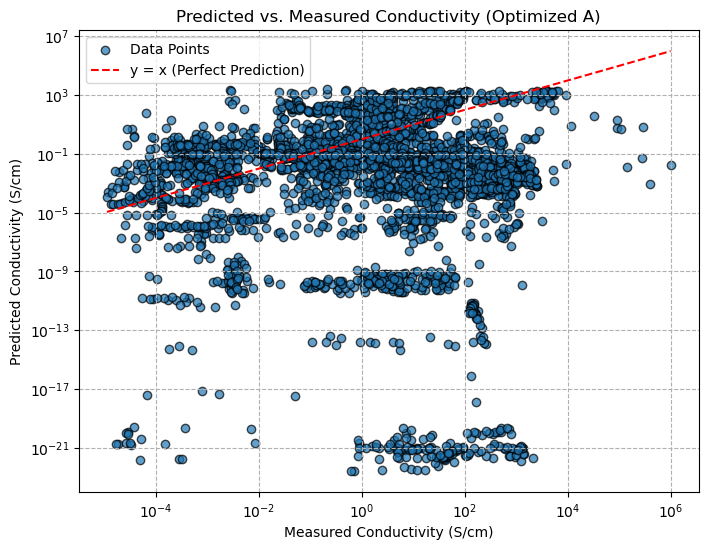

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Constants
k_B = 8.617e-5  # Boltzmann constant in eV/K

# Function to model the electrical conductivity based on the bandgap and parameter A
def conductivity_model(bandgap, temperature, A):
    return A * temperature**(-1.5) * np.exp(-bandgap / (2 * k_B * temperature))

# Objective function to minimize: sum of squared differences between measured and calculated conductivities
def objective_function(A, bandgaps, temperatures, measured_conductivities):
    calculated_conductivities = conductivity_model(bandgaps, temperatures, A)
    return np.sum((measured_conductivities - calculated_conductivities)**2)

# Ensure required columns are present
if 'calc_tauc_indirect_bandgap_eV' in valid_data.columns and 'absolute_temp_c' in valid_data.columns and 'fpm_conductivity' in valid_data.columns:
    # Filter rows with non-null values in the required columns
    filtered_data = valid_data[['calc_tauc_indirect_bandgap_eV', 'absolute_temp_c', 'fpm_conductivity']].dropna()

    # Convert temperature to Kelvin
    filtered_data['absolute_temp_k'] = filtered_data['absolute_temp_c'] + 273.15

    # Extract measured conductivity, bandgap, and temperature
    measured_conductivities = filtered_data['fpm_conductivity'].values
    bandgaps = filtered_data['calc_tauc_indirect_bandgap_eV'].values
    temperatures = filtered_data['absolute_temp_k'].values

    # Ensure valid values (positive conductivities and bandgaps)
    valid_indices = (measured_conductivities > 0) & (bandgaps > 0) & (temperatures > 0)
    measured_conductivities = measured_conductivities[valid_indices]
    bandgaps = bandgaps[valid_indices]
    temperatures = temperatures[valid_indices]

    # Define initial guess for A
    initial_A = 1e20

    # Minimize the objective function
    result = minimize(
        objective_function,
        initial_A,
        args=(bandgaps, temperatures, measured_conductivities),
        method='Nelder-Mead'
    )

    # Extract the optimized value of A
    optimized_A = result.x[0]
    print(f"Optimized value of A: {optimized_A}")

    # Calculate predicted conductivities using the optimized A
    predicted_conductivities = conductivity_model(bandgaps, temperatures, optimized_A)

    # Plot predicted vs. measured conductivity
    plt.figure(figsize=(8, 6))
    plt.scatter(measured_conductivities, predicted_conductivities, alpha=0.7, edgecolors='k', label="Data Points")
    plt.plot([measured_conductivities.min(), measured_conductivities.max()],
             [measured_conductivities.min(), measured_conductivities.max()],
             color='red', linestyle='--', label="y = x (Perfect Prediction)")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Measured Conductivity (S/cm)')
    plt.ylabel('Predicted Conductivity (S/cm)')
    plt.title('Predicted vs. Measured Conductivity (Optimized A)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
else:
    print("The required columns ('calc_tauc_indirect_bandgap_eV', 'absolute_temp_c', 'fpm_conductivity') are not present in the DataFrame.")
